In [1]:
import os
import fnmatch
import os.path
import re
import shutil
from pylab import *


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import skimage.io as io
from skimage.feature import canny, match_template, peak_local_max
from skimage.transform import resize
from skimage.draw import circle_perimeter, disk, ellipse

from scipy import ndimage, signal, spatial
import scipy.optimize as opt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.cluster import KMeans, OPTICS
import sklearn.decomposition as skld
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams.update({'font.sans-serif':'Arial'})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Defining some helpful functions

In [2]:
def fullprint(*args, **kwargs):
    from pprint import pprint
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold=numpy.inf)
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)


In [3]:
def GaussSingle(xydata, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xydata
    xo = float(xo)
    yo = float(yo)    
    a = 1/(2*sigma_x**2)
    c = 1/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g.ravel()

def lowest(a, n): return np.partition(a, n-1)[:n]
def highest(a, n): return np.partition(a, len(a)-n-1)[-n:]

def get_avg_dp(labels_arr, label_num, nbed_array):
    labelloc = np.array(np.where(labels_arr == label_num)).T
    nbed_base = np.zeros((nbed_array[0].shape[0],nbed_array[0].shape[1]))
    for i in range(len(labelloc)):
        nbed_base += nbed_array[labelloc[i]][0]
    
    return nbed_base/len(labelloc)

# Loading Data
## Previously saved into npz files, but you can do it any way you wish

In [4]:
npzfile = np.load('SMAGaWhole-160x410-360CL.npz')
#sma_nbed = npzfile['x']
sma_nbed_flat = npzfile['y']
#sma_nbed.shape
sma_nbed_flat.shape
sma_cep = np.load('smaGacepWhole-160x410-360CL.npy')
#sma_cep_im = sma_cep.reshape(sma_nbed.shape[0], sma_nbed.shape[1], sma_nbed.shape[2])
sma_cep.shape

(65600, 16384)

(65600, 16384)

In [5]:
IMG_SIZE = int(np.sqrt(sma_nbed_flat.shape[1]))
SET_SIZE = sma_nbed_flat.shape[0]

In [6]:
ScanX = 410 # Number of scan positions of 4D-STEM scan
ScanY = 160

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

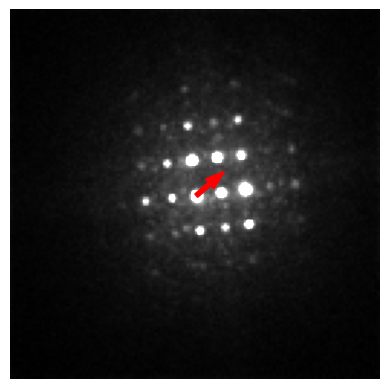

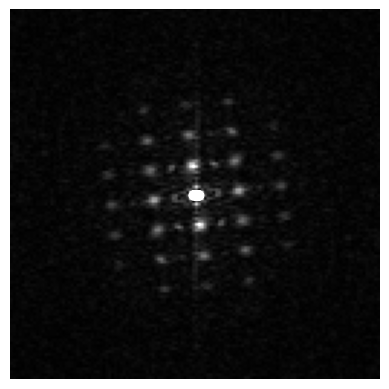

In [17]:
kk1 = 6399

nbed1 = sma_nbed_flat[kk1].reshape(IMG_SIZE, IMG_SIZE)
com_nbed1 = ndimage.center_of_mass(nbed1)

plt.figure()
plt.imshow(nbed1, cmap = 'gray')
plt.clim([0, nbed1.mean() + 2*nbed1.std()])
#plt.plot(64, 64, 'o', markersize = 8, color = 'r')
plt.arrow(x=64, y=64, dx=1*(com_nbed1[1] - 64), dy=1*(com_nbed1[0] - 64), width=1.5, color = 'r') 
#plt.plot(com_nbed1[1], com_nbed1[0], 'o', color = 'y')
#plt.colorbar()
plt.axis('off')

cep1 = sma_cep[kk1].reshape(IMG_SIZE, IMG_SIZE)
com_cep1 = ndimage.center_of_mass(cep1)

plt.figure()
plt.imshow(cep1, cmap = 'gray')
plt.clim([0, cep1.mean() + 1*cep1.std()])
#plt.plot(64, 64, 'o', color = 'r')
#plt.arrow(x=64, y=64, dx=1*(com_cep1[1] - 64), dy=1*(com_cep1[0] - 64), width=0.5, color = 'r') 
#plt.plot(com_cep1[1], com_cep1[0], 'o', color = 'y')
plt.axis('off')
#plt.colorbar()

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

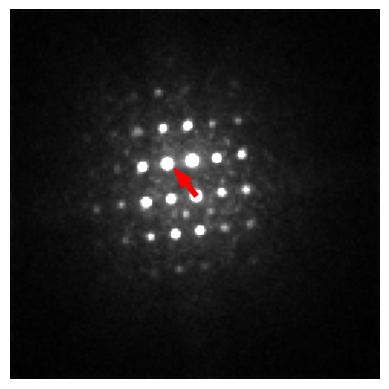

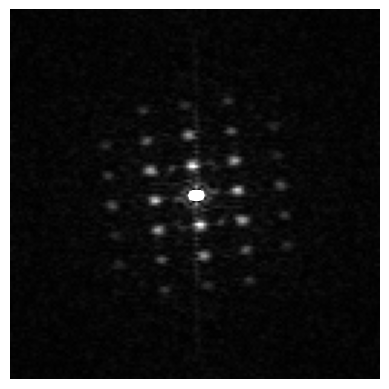

In [19]:
kk2 = 6400

nbed2 = sma_nbed_flat[kk2].reshape(IMG_SIZE, IMG_SIZE)
com_nbed2 = ndimage.center_of_mass(nbed2)

plt.figure()
plt.imshow(nbed2, cmap = 'gray')
plt.clim([0, nbed2.mean() + 2*nbed2.std()])
#plt.plot(64, 64, 'o', color = 'r')
plt.arrow(x=64, y=64, dx=1*(com_nbed2[1] - 64), dy=1*(com_nbed2[0] - 64), width=1.5, color = 'r') 
#plt.plot(com_nbed2[1], com_nbed2[0], 'o', color = 'y')
#plt.colorbar()
plt.axis('off')

cep2 = sma_cep[kk2].reshape(IMG_SIZE, IMG_SIZE)
com_cep2 = ndimage.center_of_mass(cep2)

plt.figure()
plt.imshow(cep2, cmap = 'gray')
plt.clim([0, cep2.mean() + 1*cep2.std()])
#plt.plot(64, 64, 'o', color = 'r')
#plt.arrow(x=64, y=64, dx=1*(com_cep2[1] - 64), dy=1*(com_cep2[0] - 64), width=0.5, color = 'r') 
#plt.plot(com_cep2[1], com_cep2[0], 'o', color = 'y')
plt.axis('off')
#plt.colorbar()

# PCA

In [7]:
%%time
pca = skld.PCA(n_components = 5, random_state = 0)
sma_pca = pca.fit_transform(sma_nbed_flat)

CPU times: total: 31.3 s
Wall time: 6.94 s


In [8]:
%%time
pca2 = skld.PCA(n_components = 5, random_state = 0)
sma_cep_pca = pca2.fit_transform(sma_cep)

CPU times: total: 49.9 s
Wall time: 11.4 s


In [31]:
pca1c = pca.components_
pca2c = pca2.components_

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

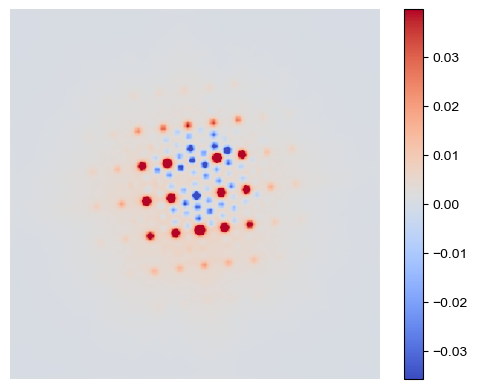

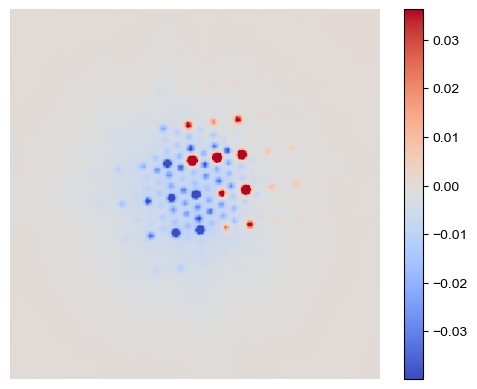

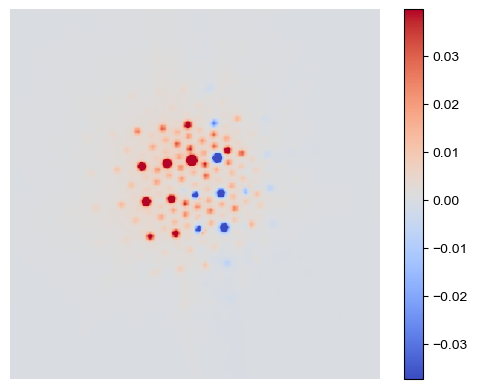

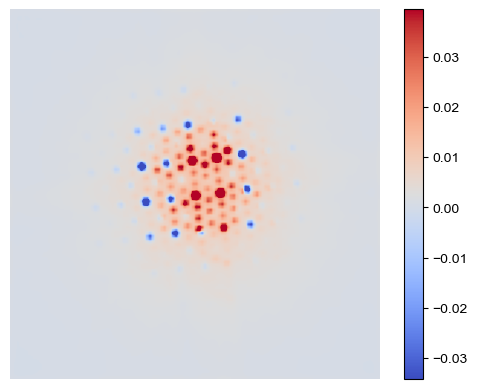

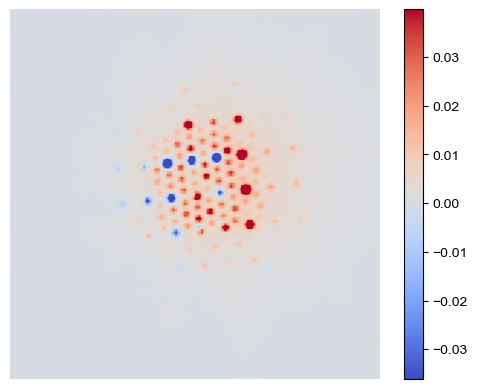

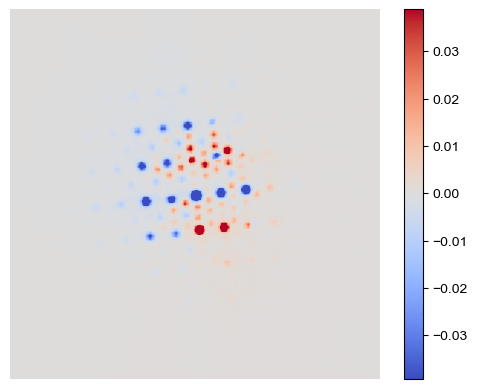

In [54]:
for i in range(6):
    plt.figure()
    plt.imshow(pca1c[i].reshape(IMG_SIZE, IMG_SIZE), cmap = 'coolwarm')
    plt.axis('off')
    plt.colorbar()
    plt.clim([pca1c[i].mean() - 5*pca1c[i].std(), pca1c[i].mean() + 5*pca1c[i].std()])

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 640x480 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

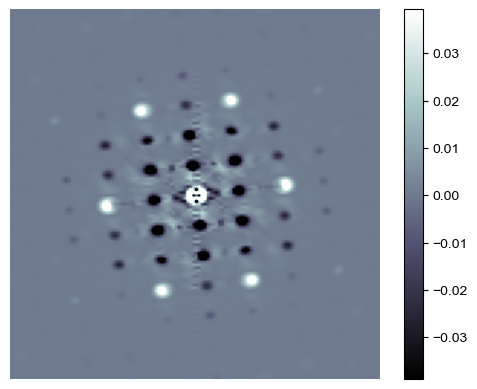

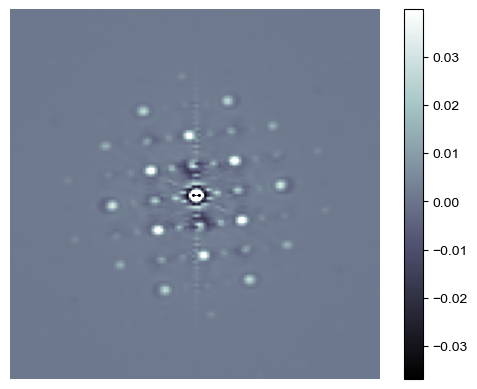

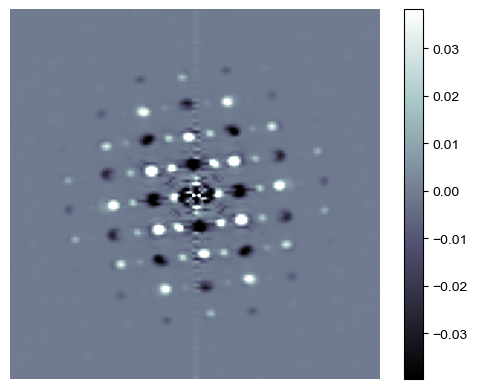

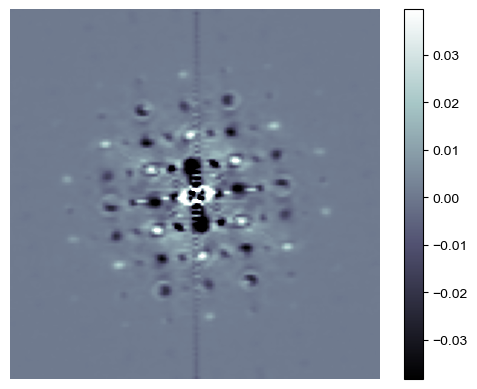

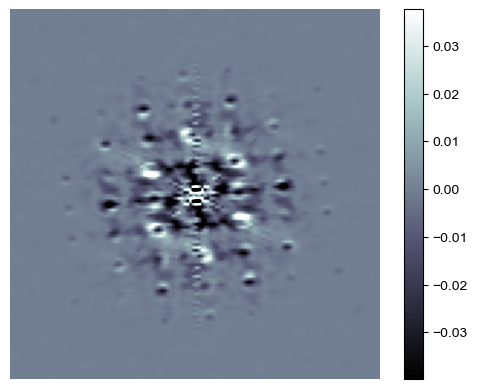

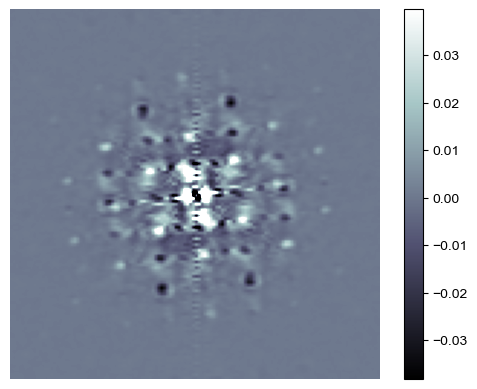

In [58]:
for i in range(6):
    plt.figure()
    plt.imshow(pca2c[i].reshape(IMG_SIZE, IMG_SIZE), cmap = 'bone')
    plt.axis('off')
    plt.colorbar()
    plt.clim([pca2c[i].mean() - 5*pca2c[i].std(), pca2c[i].mean() + 5*pca2c[i].std()])

In [9]:
kp_inertia = []
for i in range(2, 10):
    temp_inertia = []
    for j in range(0,10):
        kmeans_pca_run = KMeans(n_clusters = i, n_init = 10).fit(sma_pca[:,:])
        temp_inertia.append(kmeans_pca_run.inertia_)
    kp_inertia.append(np.asarray(temp_inertia).mean())
kp_inertia = np.asarray(kp_inertia)  

In [10]:
np.round(kp_inertia/10000,2)

array([6.8 , 5.17, 4.28, 3.75, 3.27, 2.91, 2.7 , 2.5 ], dtype=float32)

([<matplotlib.axis.XTick at 0x1bc45cefa60>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

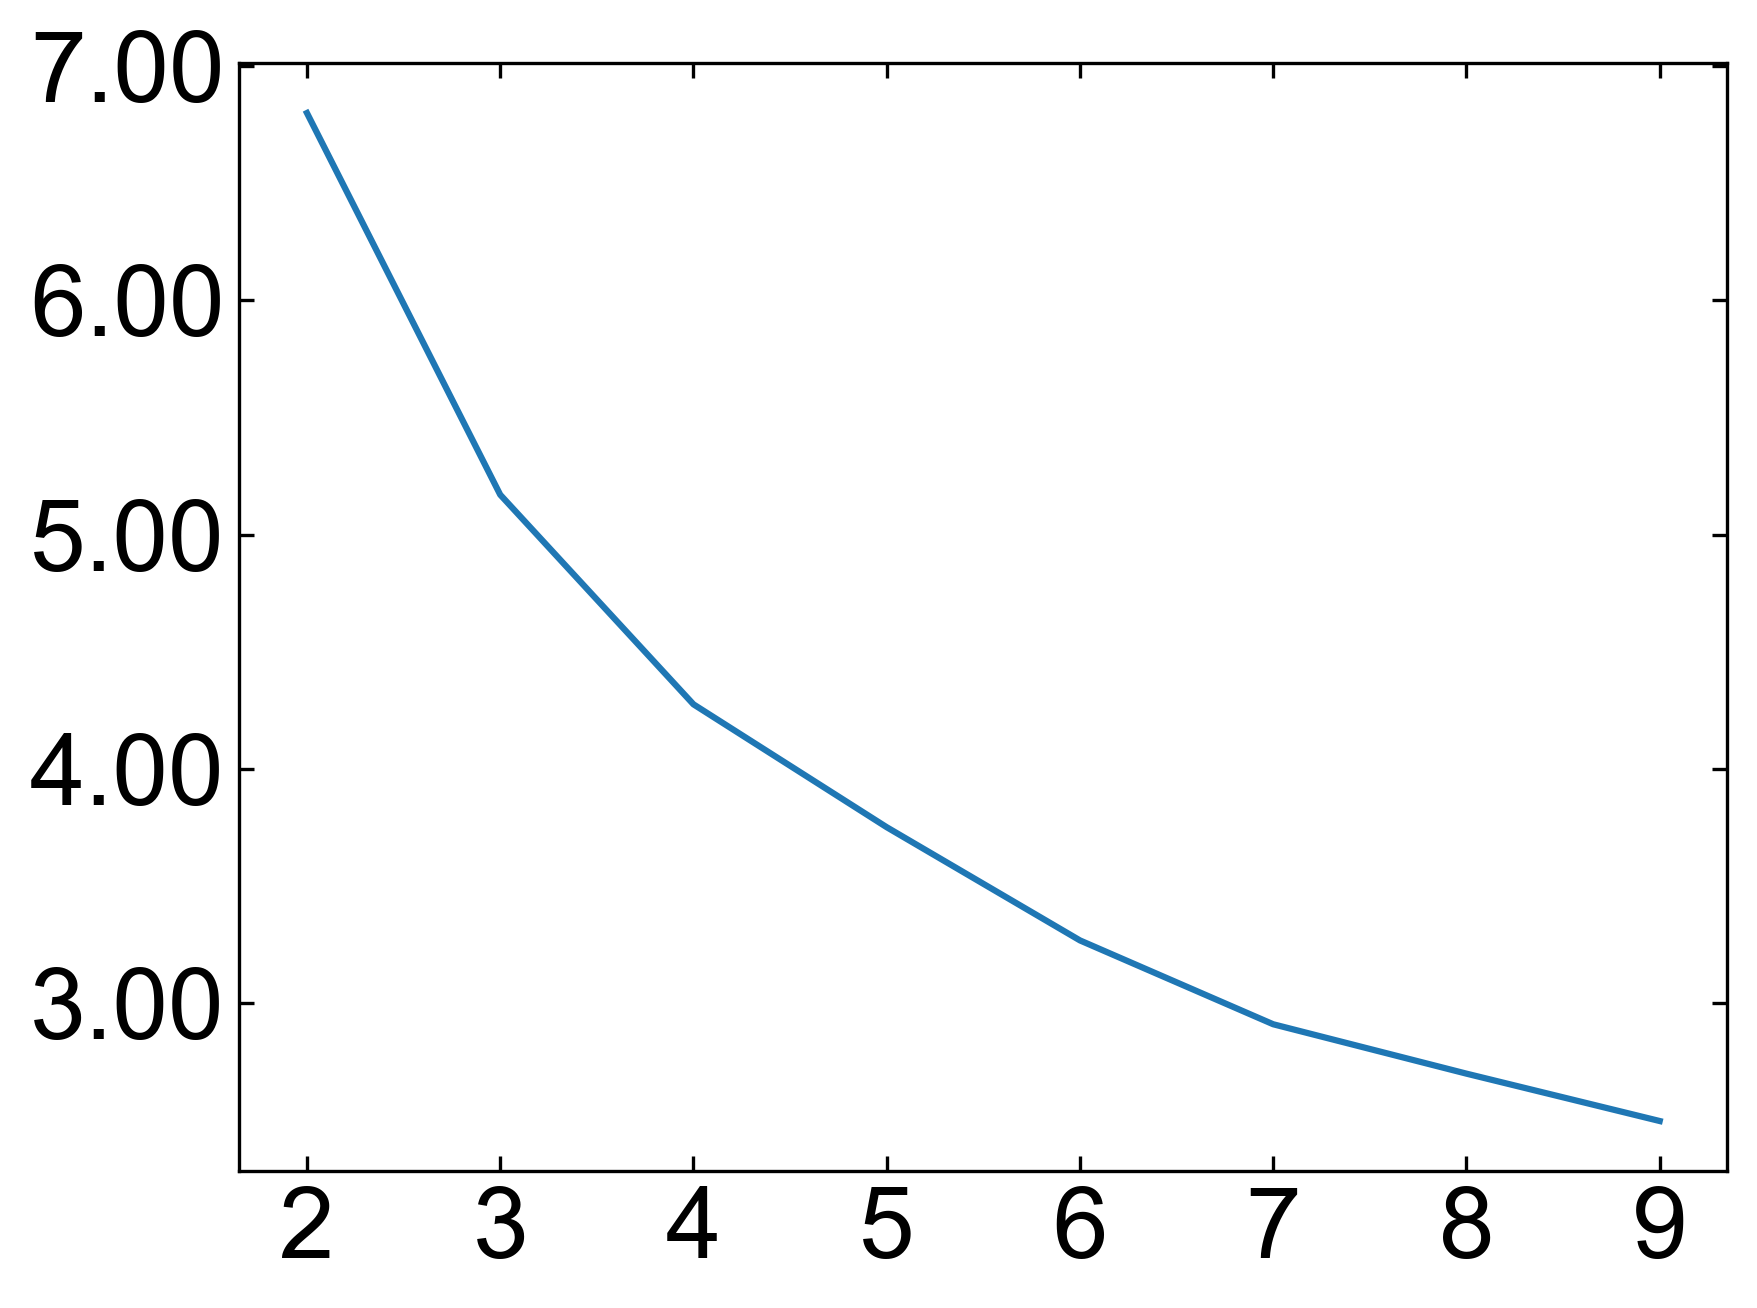

In [12]:
fig, ax = plt.subplots(dpi = 300)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,10,1)
ax.plot(n[0:9], kp_inertia[0:9]/10000)
plt.xticks(n[0:9],n[0:9])

In [13]:
kcp_inertia = []
for i in range(2, 10):
    temp_inertia = []
    for j in range(0,10):
        kmeans_cep_pca_run = KMeans(n_clusters = i, n_init = 10).fit(sma_cep_pca[:,:])
        temp_inertia.append(kmeans_cep_pca_run.inertia_)
    kcp_inertia.append(np.asarray(temp_inertia).mean())
kcp_inertia = np.asarray(kcp_inertia)

([<matplotlib.axis.XTick at 0x1bc47ae1630>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

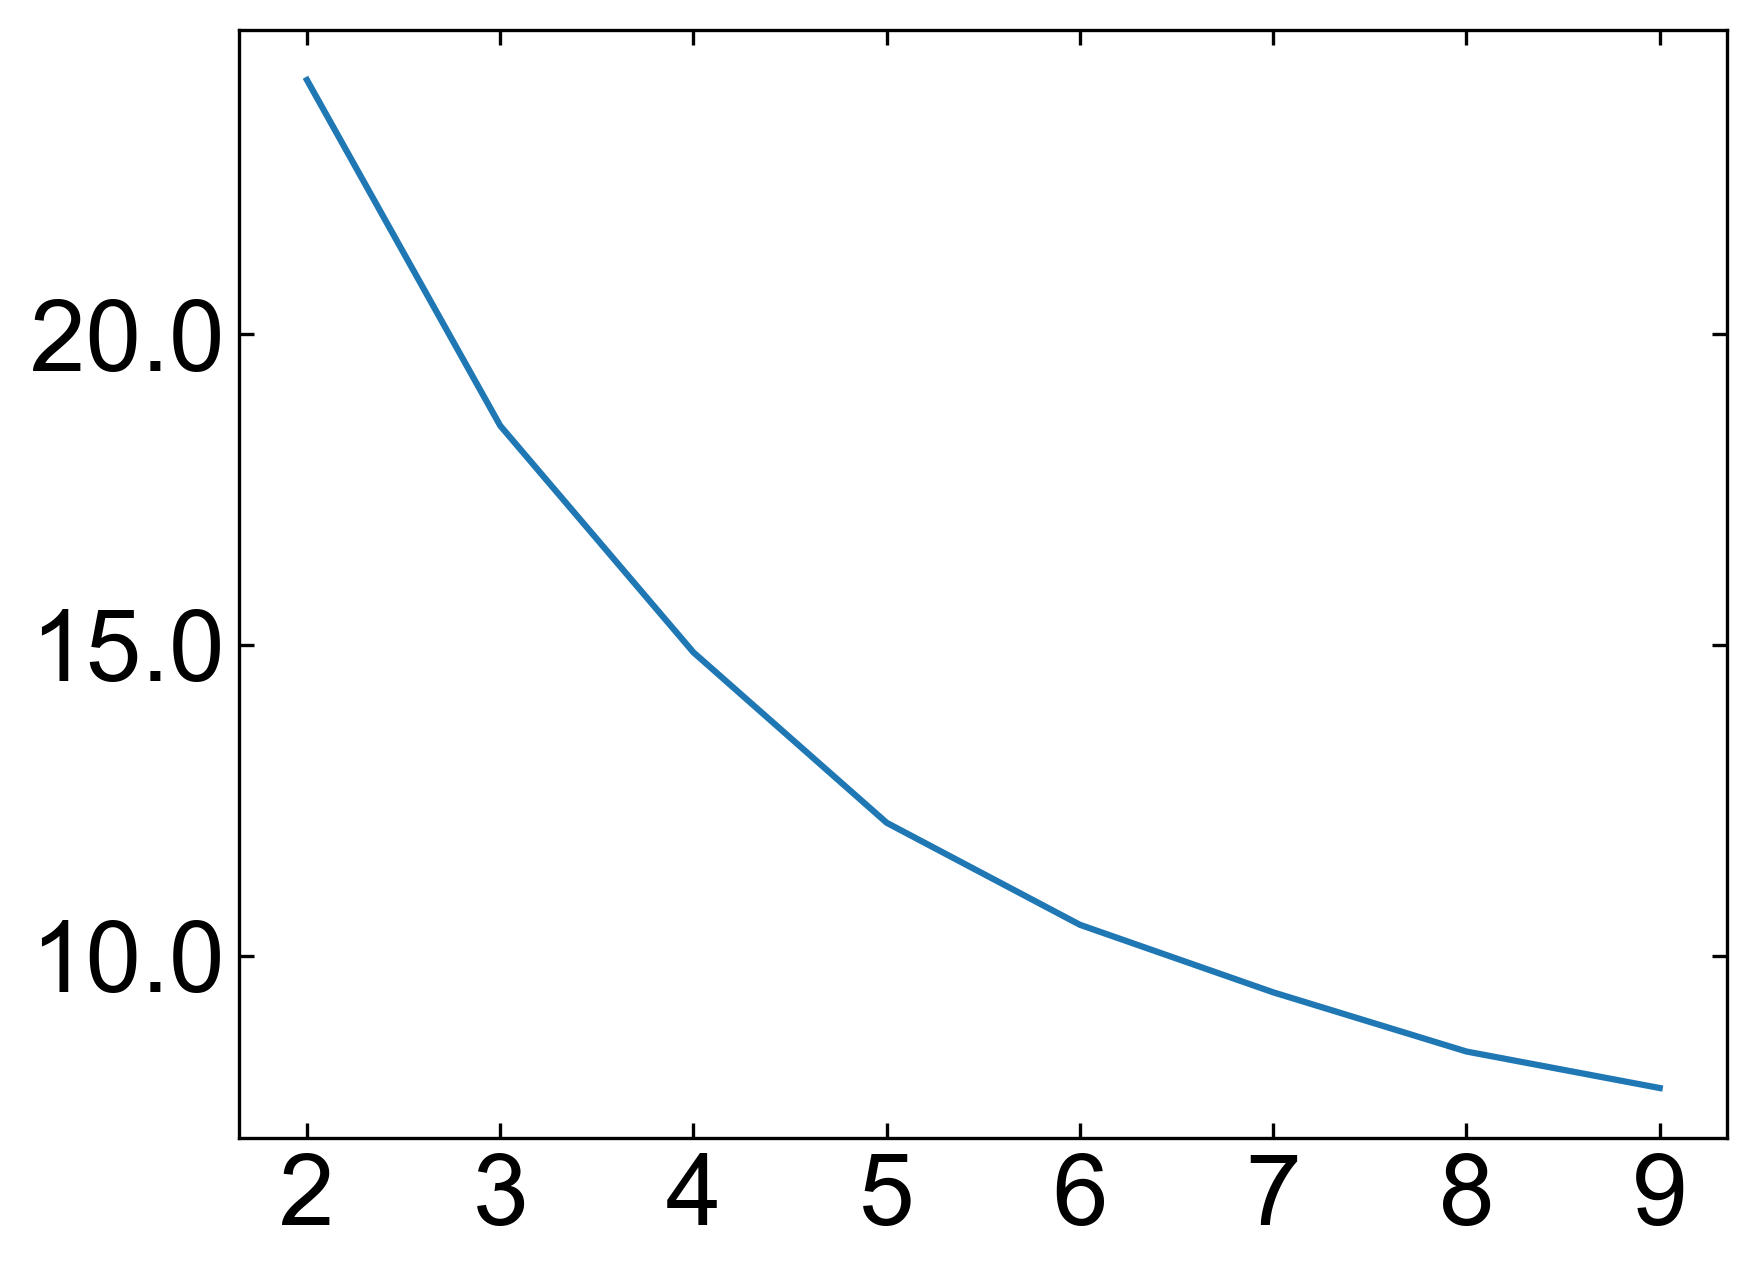

In [14]:
fig, ax = plt.subplots(dpi = 300)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,10,1)
ax.plot(n[0:9], kcp_inertia[0:9])
plt.xticks(n[0:9],n[0:9])

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_12640\1590780831.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_pca, cmap = cm.get_cmap('RdYlBu', nckp))


(-0.5, 159.5, 409.5, -0.5)

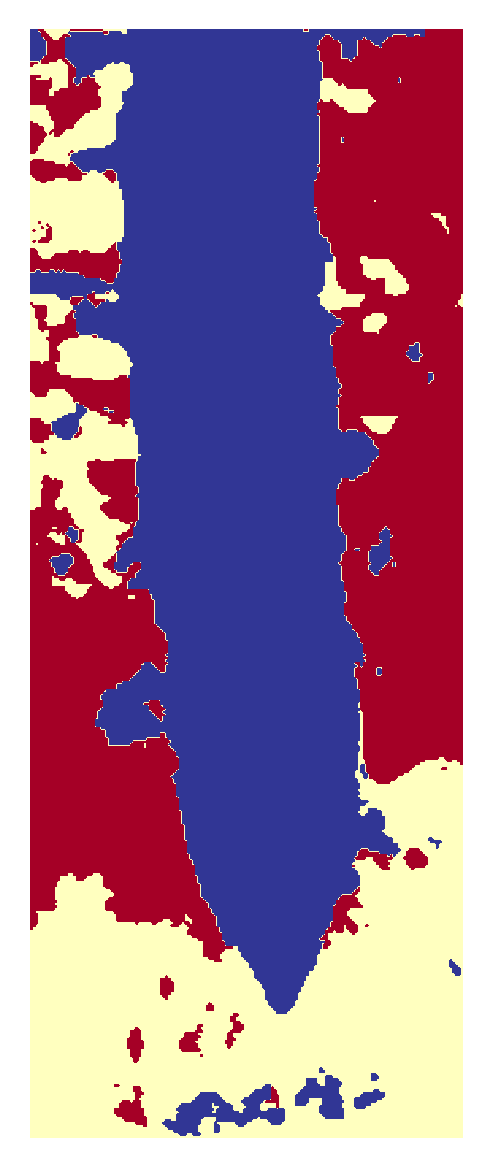

In [17]:
nckp = 3
kmeans_pca = KMeans(n_clusters = nckp, n_init = 10).fit(sma_pca[:,:]) # k = # of clusters

plt.figure(dpi = 300)
cluster_map_pca = (np.reshape(kmeans_pca.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_pca, cmap = cm.get_cmap('RdYlBu', nckp))
#plt.colorbar(ticks = np.arange(nckp)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [32]:
pca_avg_dict = {}
for x in range(nckp):
    pca_avg_dict["nbed_{0}_avg_pca".format(x)] = get_avg_dp(kmeans_pca.labels_, x, sma_nbed_flat.reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

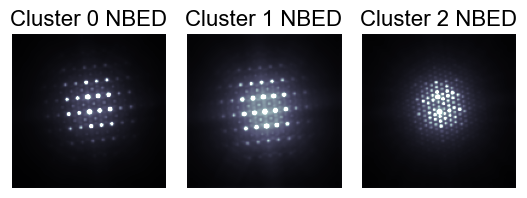

In [43]:
clim_ref2 = pca_avg_dict["nbed_2_avg_pca"]
n_max = clim_ref2.mean() + 3*clim_ref2.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (6, 2))
im1 = ax1.imshow(pca_avg_dict["nbed_0_avg_pca"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 16)
im2 = ax2.imshow(pca_avg_dict["nbed_1_avg_pca"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 16)
im3 = ax3.imshow(pca_avg_dict["nbed_2_avg_pca"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 16)

fig.subplots_adjust(right=1)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_12640\3351686517.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_cep_pca, cmap = cm.get_cmap('RdYlBu',nckpc))


(-0.5, 159.5, 409.5, -0.5)

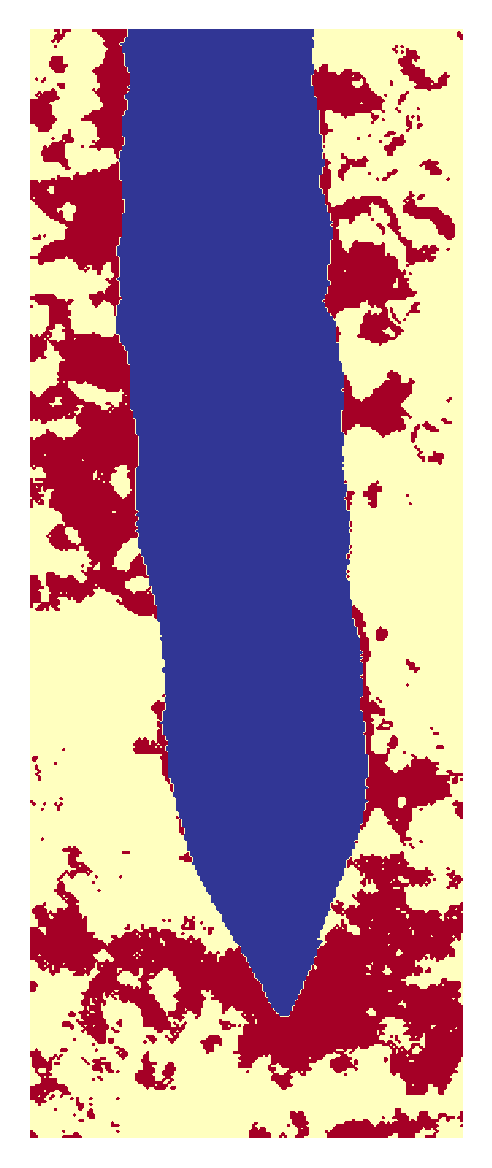

In [30]:
nckpc = 3
kmeans_cep_pca = KMeans(n_clusters = nckpc, n_init = 10).fit(sma_cep_pca[:,:]) # k = # of clusters

plt.figure(dpi = 300)
plt.tight_layout(pad=0)
cluster_map_cep_pca = (np.reshape(kmeans_cep_pca.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_cep_pca, cmap = cm.get_cmap('RdYlBu',nckpc))
#plt.colorbar(ticks = np.arange(nckpc)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [107]:
pca_cep_avg_dict = {}
for x in range(nckpc):
    pca_cep_avg_dict["nbed_{0}_avg_pca_cep".format(x)] = get_avg_dp(kmeans_cep_pca.labels_, x, sma_nbed_flat.reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))
for x in range(nckpc):
    pca_cep_avg_dict["cep_{0}_avg_pca_cep".format(x)] = get_avg_dp(kmeans_cep_pca.labels_, x, sma_cep.reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

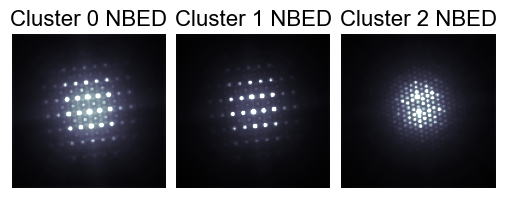

In [117]:
clim_ref = pca_cep_avg_dict["nbed_1_avg_pca_cep"]
n_max = clim_ref.mean() + 3*clim_ref.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (6, 2))
im1 = ax1.imshow(pca_cep_avg_dict["nbed_0_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 16)
im2 = ax2.imshow(pca_cep_avg_dict["nbed_1_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 16)
im3 = ax3.imshow(pca_cep_avg_dict["nbed_2_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 16)

fig.subplots_adjust(right=0.95)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 Cep')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 Cep')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 Cep')

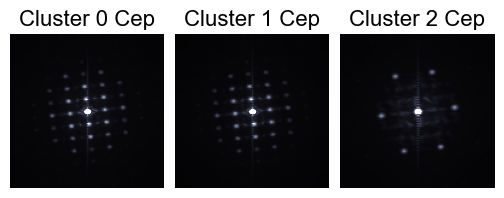

In [118]:
clim_ref = pca_cep_avg_dict["cep_1_avg_pca_cep"]
n_max = clim_ref.mean() + 1*clim_ref.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (6, 2))
im1 = ax1.imshow(pca_cep_avg_dict["cep_0_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 Cep', fontsize = 16)
im2 = ax2.imshow(pca_cep_avg_dict["cep_1_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 Cep', fontsize = 16)
im3 = ax3.imshow(pca_cep_avg_dict["cep_2_avg_pca_cep"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 Cep', fontsize = 16)

fig.subplots_adjust(right=0.95)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

# NMF & Strain Mapping

In [7]:
%%time
nmf = skld.NMF(n_components=10, solver = 'mu', max_iter = 10000, init = None, random_state = 0)
sma_nmf = nmf.fit_transform(sma_nbed_flat)
nmf.n_iter_

CPU times: total: 18min 3s
Wall time: 3min 59s


390

In [18]:
%%time
nmf22 = skld.NMF(n_components=5, solver = 'mu', max_iter = 15000, init = None, random_state = 0)
sma_cep_nmf2 = nmf22.fit_transform(cep_nmf_rec)
nmf22.n_iter_

CPU times: total: 1h 3min 56s
Wall time: 15min 1s


830

In [19]:
nmf22.reconstruction_err_

1.9345557530691617

In [15]:
np.save('smaGanmfWhole-160x410', sma_nmf)
np.save('smaGanmfcepWhole-160x410', sma_cep_nmf)

In [44]:
sma_nmf = np.load('smaGanmfWhole-160x410.npy')
sma_cep_nmf = np.load('smaGanmfcepWhole-160x410.npy')

In [8]:
H0 = nmf.components_
H0.shape

(10, 16384)

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

(-0.5, 127.5, 127.5, -0.5)

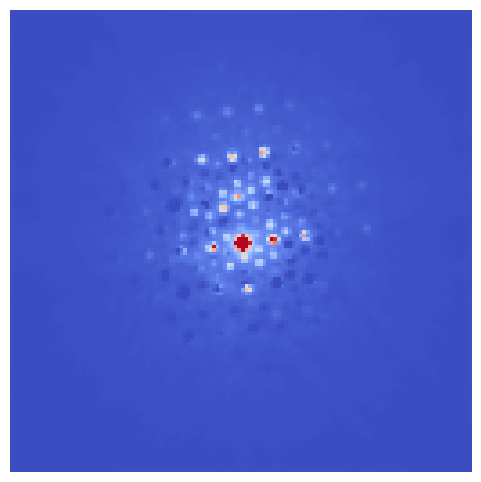

(-0.5, 127.5, 127.5, -0.5)

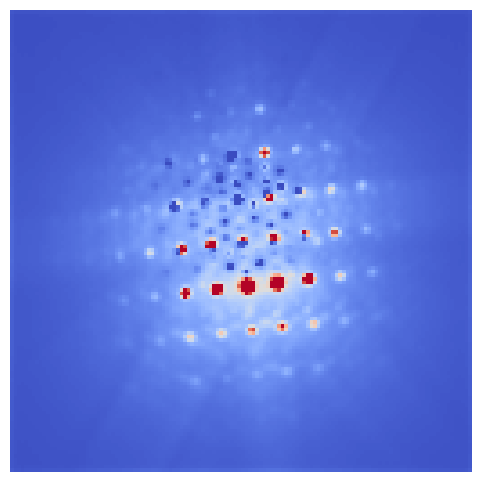

(-0.5, 127.5, 127.5, -0.5)

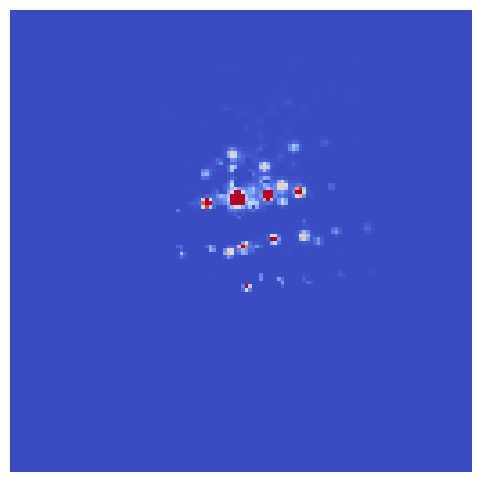

(-0.5, 127.5, 127.5, -0.5)

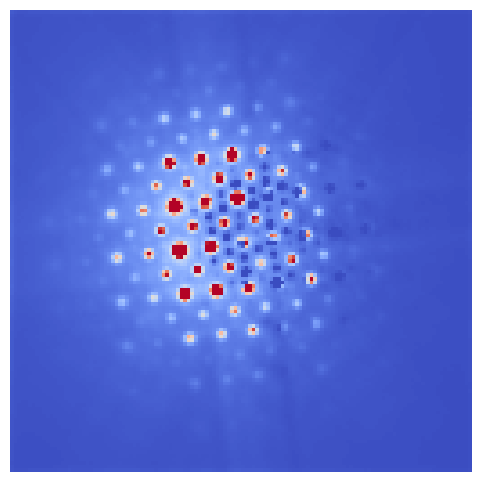

(-0.5, 127.5, 127.5, -0.5)

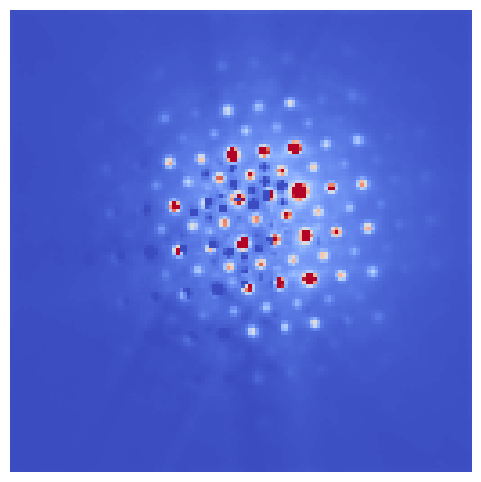

In [16]:
for i in range(5):
    fig, (ax1) = plt.subplots(1,1, figsize = (6,6))
    im1 = ax1.imshow(H0[i].reshape(IMG_SIZE, IMG_SIZE), cmap = 'coolwarm')
    ax1.axis('off')
    #ax1.set_title('nmf1 - 10 comp', fontsize = 26)
    im1.set_clim(0, 3*H0[i].std())
    # divider = make_axes_locatable(ax1)
    # cax = divider.append_axes('right', size='5%', pad=0.08)
    # fig.colorbar(im1, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)


#     fig.subplots_adjust(right=.9)
#     cbar_ax = fig.add_axes([0.9, 0.1, 0.015, 0.8]) # upper and lower limits, width, and length
#     fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 20)
#     plt.subplots_adjust(wspace=0)
#     plt.show()

    plt.show()

(-0.5, 159.5, 409.5, -0.5)

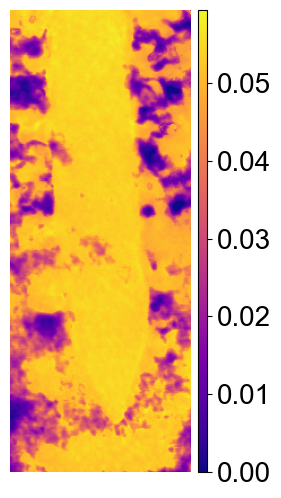

(-0.5, 159.5, 409.5, -0.5)

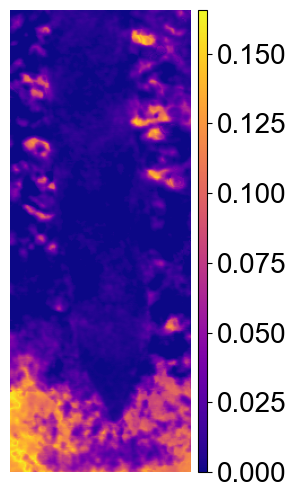

(-0.5, 159.5, 409.5, -0.5)

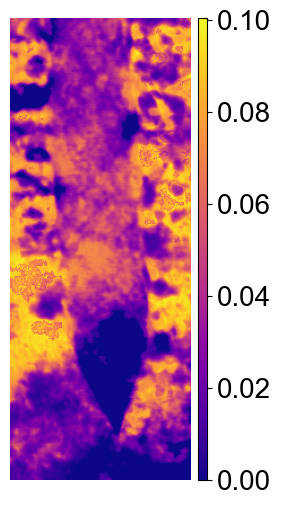

(-0.5, 159.5, 409.5, -0.5)

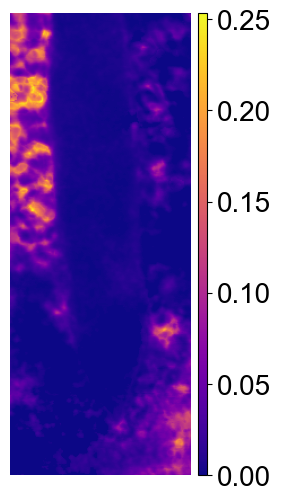

(-0.5, 159.5, 409.5, -0.5)

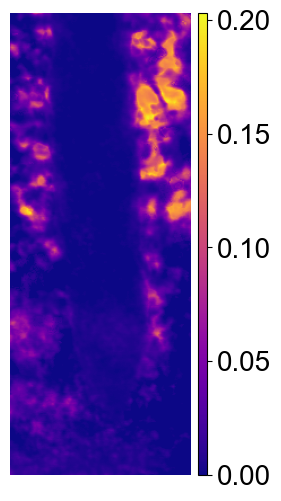

In [15]:
for i in range(5):
    fig, (ax1) = plt.subplots(1,1, figsize = (12,6))
    im1 = ax1.imshow(sma_nmf[:,i].reshape(ScanX, ScanY).reshape(ScanX, ScanY), cmap = 'plasma')
    ax1.axis('off')
    #ax1.set_title('Old - Comp ' + str(i + 1), fontsize = 20)
    #im1.set_clim(0, 2*H1[i].std())
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.08)
    fig.colorbar(im1, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)



#     fig.subplots_adjust(right=.9)
#     cbar_ax = fig.add_axes([0.9, 0.1, 0.015, 0.8]) # upper and lower limits, width, and length
#     fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 20)
#     plt.subplots_adjust(wspace=0)
#     plt.show()

    plt.show()

# Calculations to determine ideal number of components for NMF and clusters for K-means clustering

In [11]:
%%time
rmse_nmf = []
best_n_nmf = 0
actual_rmse_nmf = 1000000
for i in range(2,16):
    temp_rmse = []
    for j in range(0,10):
        nmf_run = skld.NMF(n_components = i, solver = 'mu', max_iter = 5000)
        nmf_run_fit = nmf_run.fit_transform(sma_nbed_flat)
        nmf_rec_flat = (nmf_run.inverse_transform(nmf_run_fit))
        curr_rmse = mean_squared_error(sma_nbed_flat, nmf_rec_flat, squared = False)
        temp_rmse.append(curr_rmse)
    avg_rmse = np.asarray(temp_rmse).mean()
    rmse_nmf.append(np.asarray(avg_rmse).mean())
    if avg_rmse < actual_rmse_nmf:
        actual_rmse_nmf = avg_rmse
        best_n_nmf = i
    else:
        actual_rmse_nmf = actual_rmse_nmf
        best_n_nmf = best_n_nmf
    

CPU times: total: 1d 17h 47min 5s
Wall time: 8h 59min 27s


In [65]:
np.save('rmse_nmf_SMAWholePrec', np.array(rmse_nmf))
#rmse_nmf = np.load('rmse_nmf_SMAWholePrec.npy')

<Figure size 1920x1440 with 0 Axes>

Text(0.5, 1.0, 'RMSE for NBED Data')

Text(0, 0.5, 'RMSE')

Text(0.5, 0, 'Number of Components')

([<matplotlib.axis.XTick at 0x2893e03a7d0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

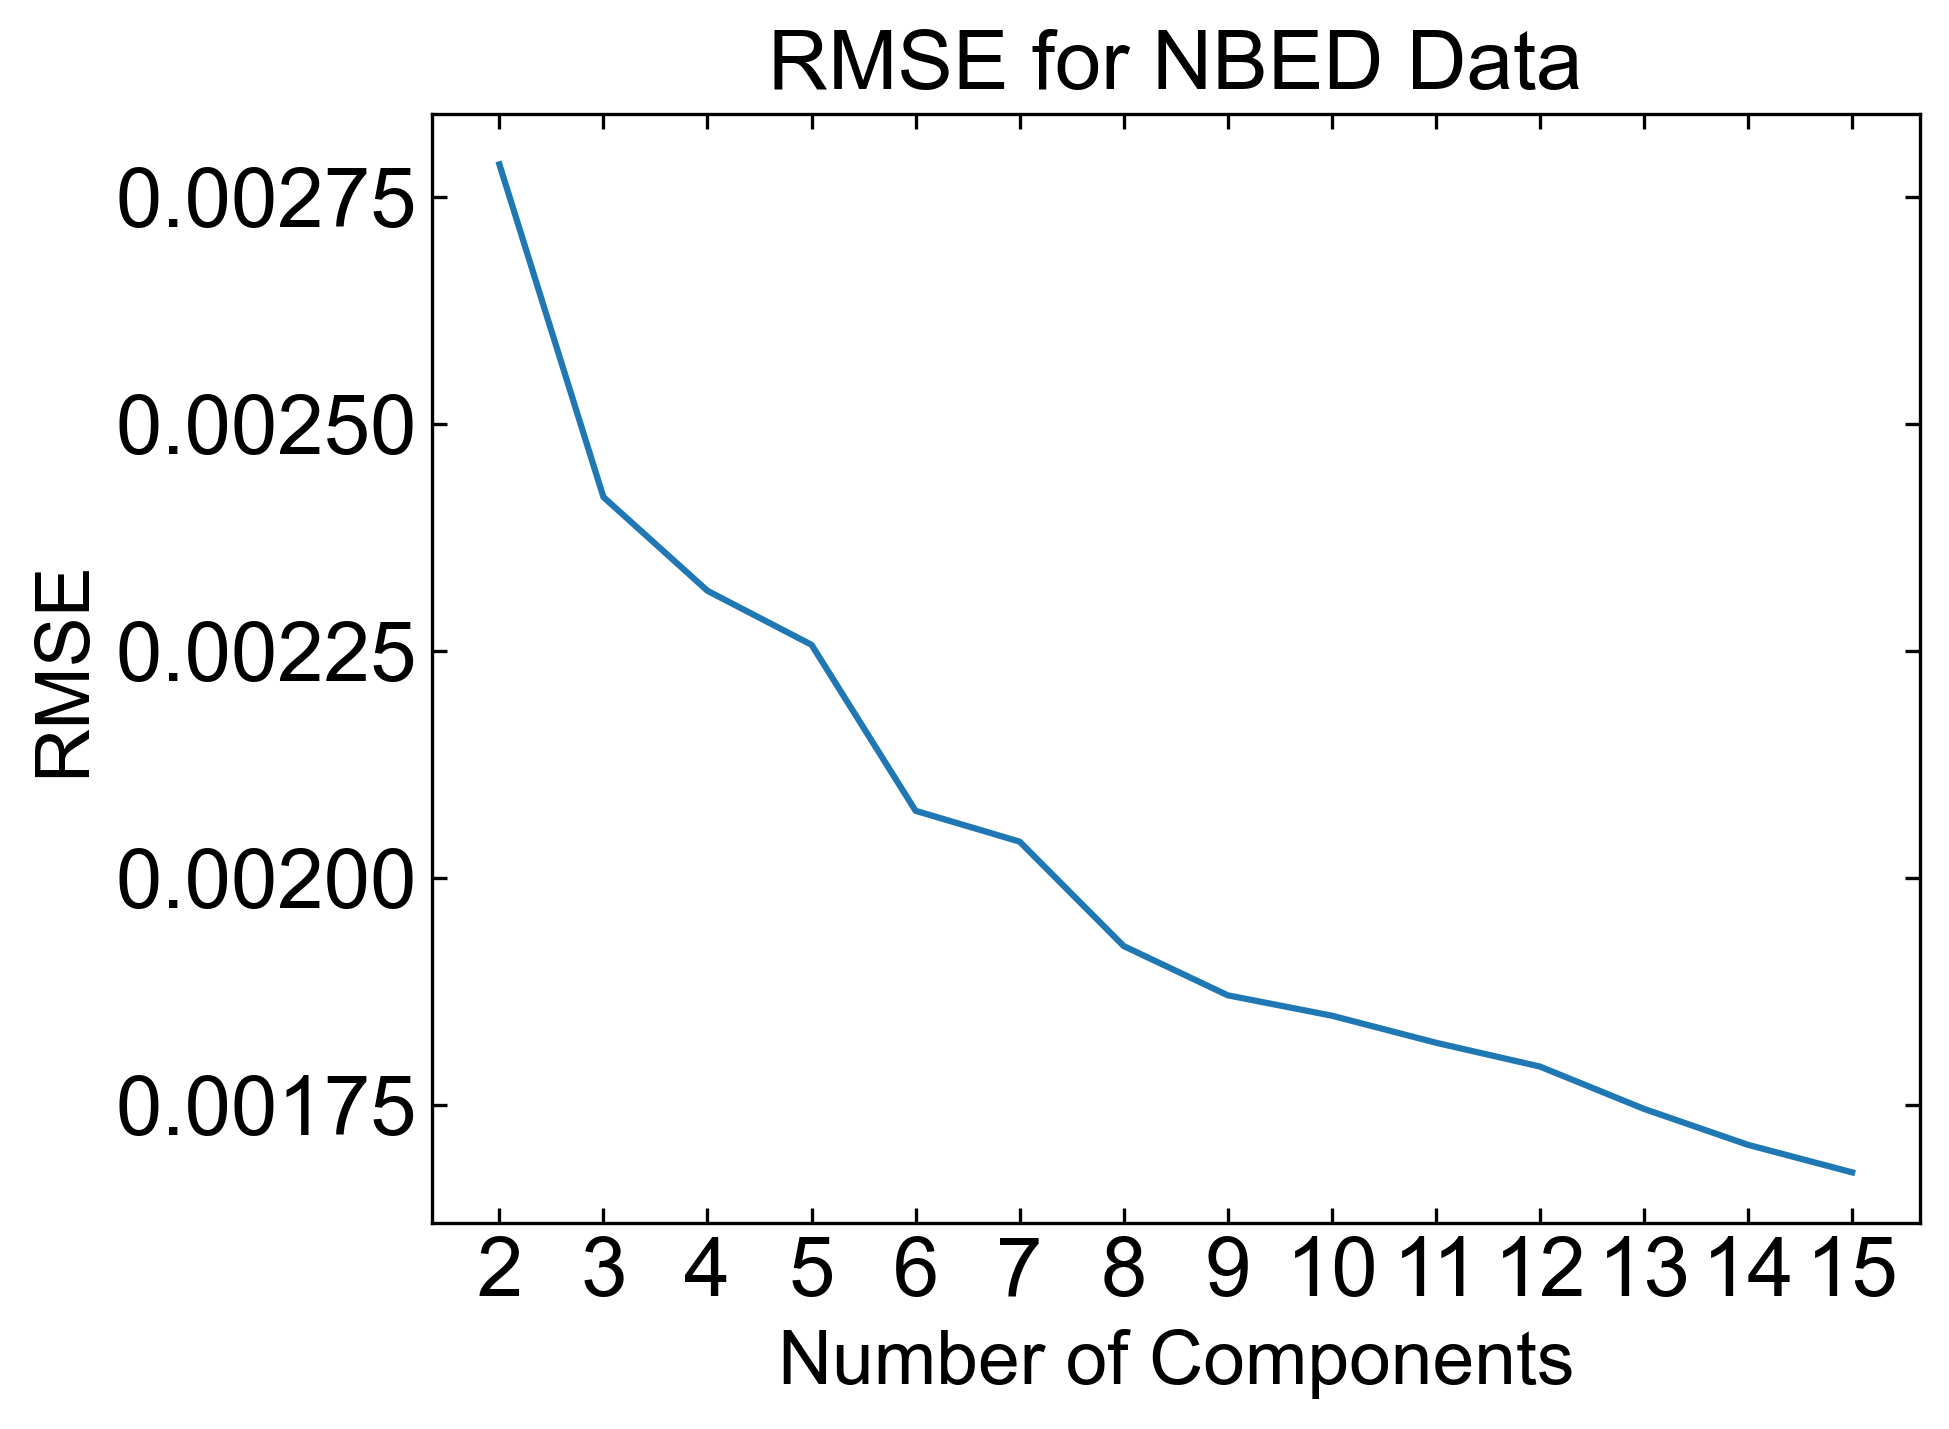

In [66]:
plt.figure(dpi = 300)
x = np.arange(2,16,1)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
plt.plot(x, rmse_nmf)
plt.title('RMSE for NBED Data', fontsize = 20)
plt.ylabel('RMSE', fontsize = 18)
plt.xlabel('Number of Components', fontsize = 18)
plt.xticks(x, x)

In [48]:
kn_inertia = []
for i in range(2, 12):
    temp_inertia = []
    for j in range(0,10):
        kmeans_nmf_run = KMeans(n_clusters = i, n_init = 10).fit(sma_nmf[:,:5])
        temp_inertia.append(kmeans_nmf_run.inertia_)
    kn_inertia.append(np.asarray(temp_inertia).mean())
kn_inertia = np.asarray(kn_inertia)

In [46]:
# kn_inertia = np.asarray(kn_inertia)
# kn_inertia.mean()

<Figure size 1920x1440 with 0 Axes>

([<matplotlib.axis.XTick at 0x1bc51c50f10>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

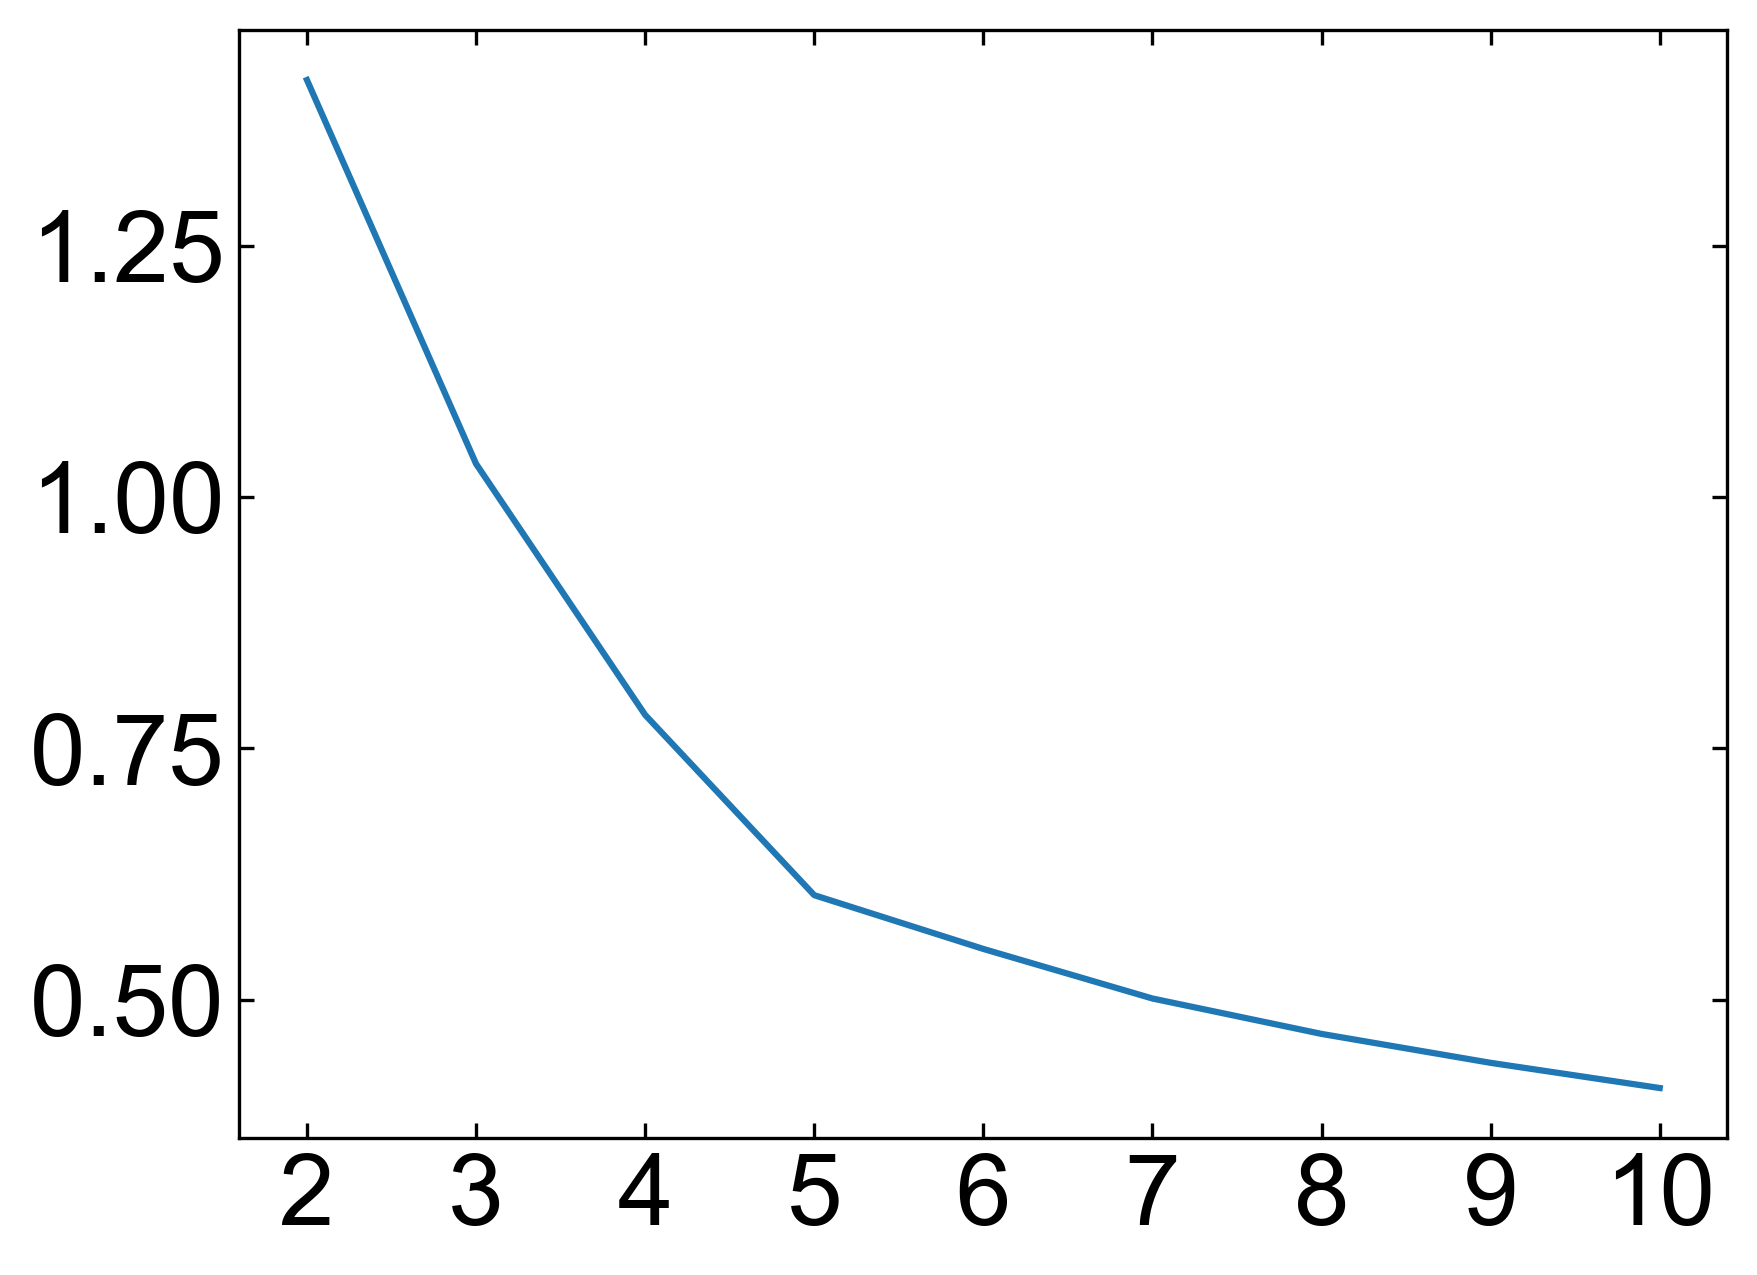

In [49]:
plt.figure(dpi = 300)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,12,1)
plt.plot(n[0:9], kn_inertia[0:9]/100)
plt.xticks(n[0:9],n[0:9])

In [14]:
%%time
rmse_nmf_cep = []
best_n_nmfcep = 0
actual_rmse_nmfcep = 1000000
for i in range(2,16):
    temp_rmse = []
    for j in range(0,10):
        nmf_run = skld.NMF(n_components = i, solver = 'mu', max_iter = 5000)
        nmf_run_fit = nmf_run.fit_transform(sma_cep)
        cep_nmf_rec_flat = (nmf_run.inverse_transform(nmf_run_fit))
        curr_rmse = mean_squared_error(sma_cep, cep_nmf_rec_flat, squared = False)
        temp_rmse.append(curr_rmse)
    avg_rmse = np.asarray(temp_rmse).mean()
    rmse_nmf_cep.append(np.asarray(avg_rmse).mean())
    if avg_rmse < actual_rmse_nmfcep:
        actual_rmse_nmfcep = avg_rmse
        best_n_nmfcep = i
    else:
        actual_rmse_nmfcep = actual_rmse_nmfcep
        best_n_nmfcep = best_n_nmfcep
    

CPU times: total: 4d 12h 49min 17s
Wall time: 1d 2s


In [62]:
#rmse_nmf_cep = np.asarray(rmse_nmf_cep)
#np.save('rmse_nmfcep_SMAWholePrec', rmse_nmf_cep)
rmse_nmf_cep = np.load('rmse_nmfcep_SMAWholePrec.npy')

Text(0.5, 1.0, 'RMSE for Cepstrum Data')

Text(0, 0.5, 'RMSE')

Text(0.5, 0, 'Number of Components')

([<matplotlib.axis.XTick at 0x2893d7d6260>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

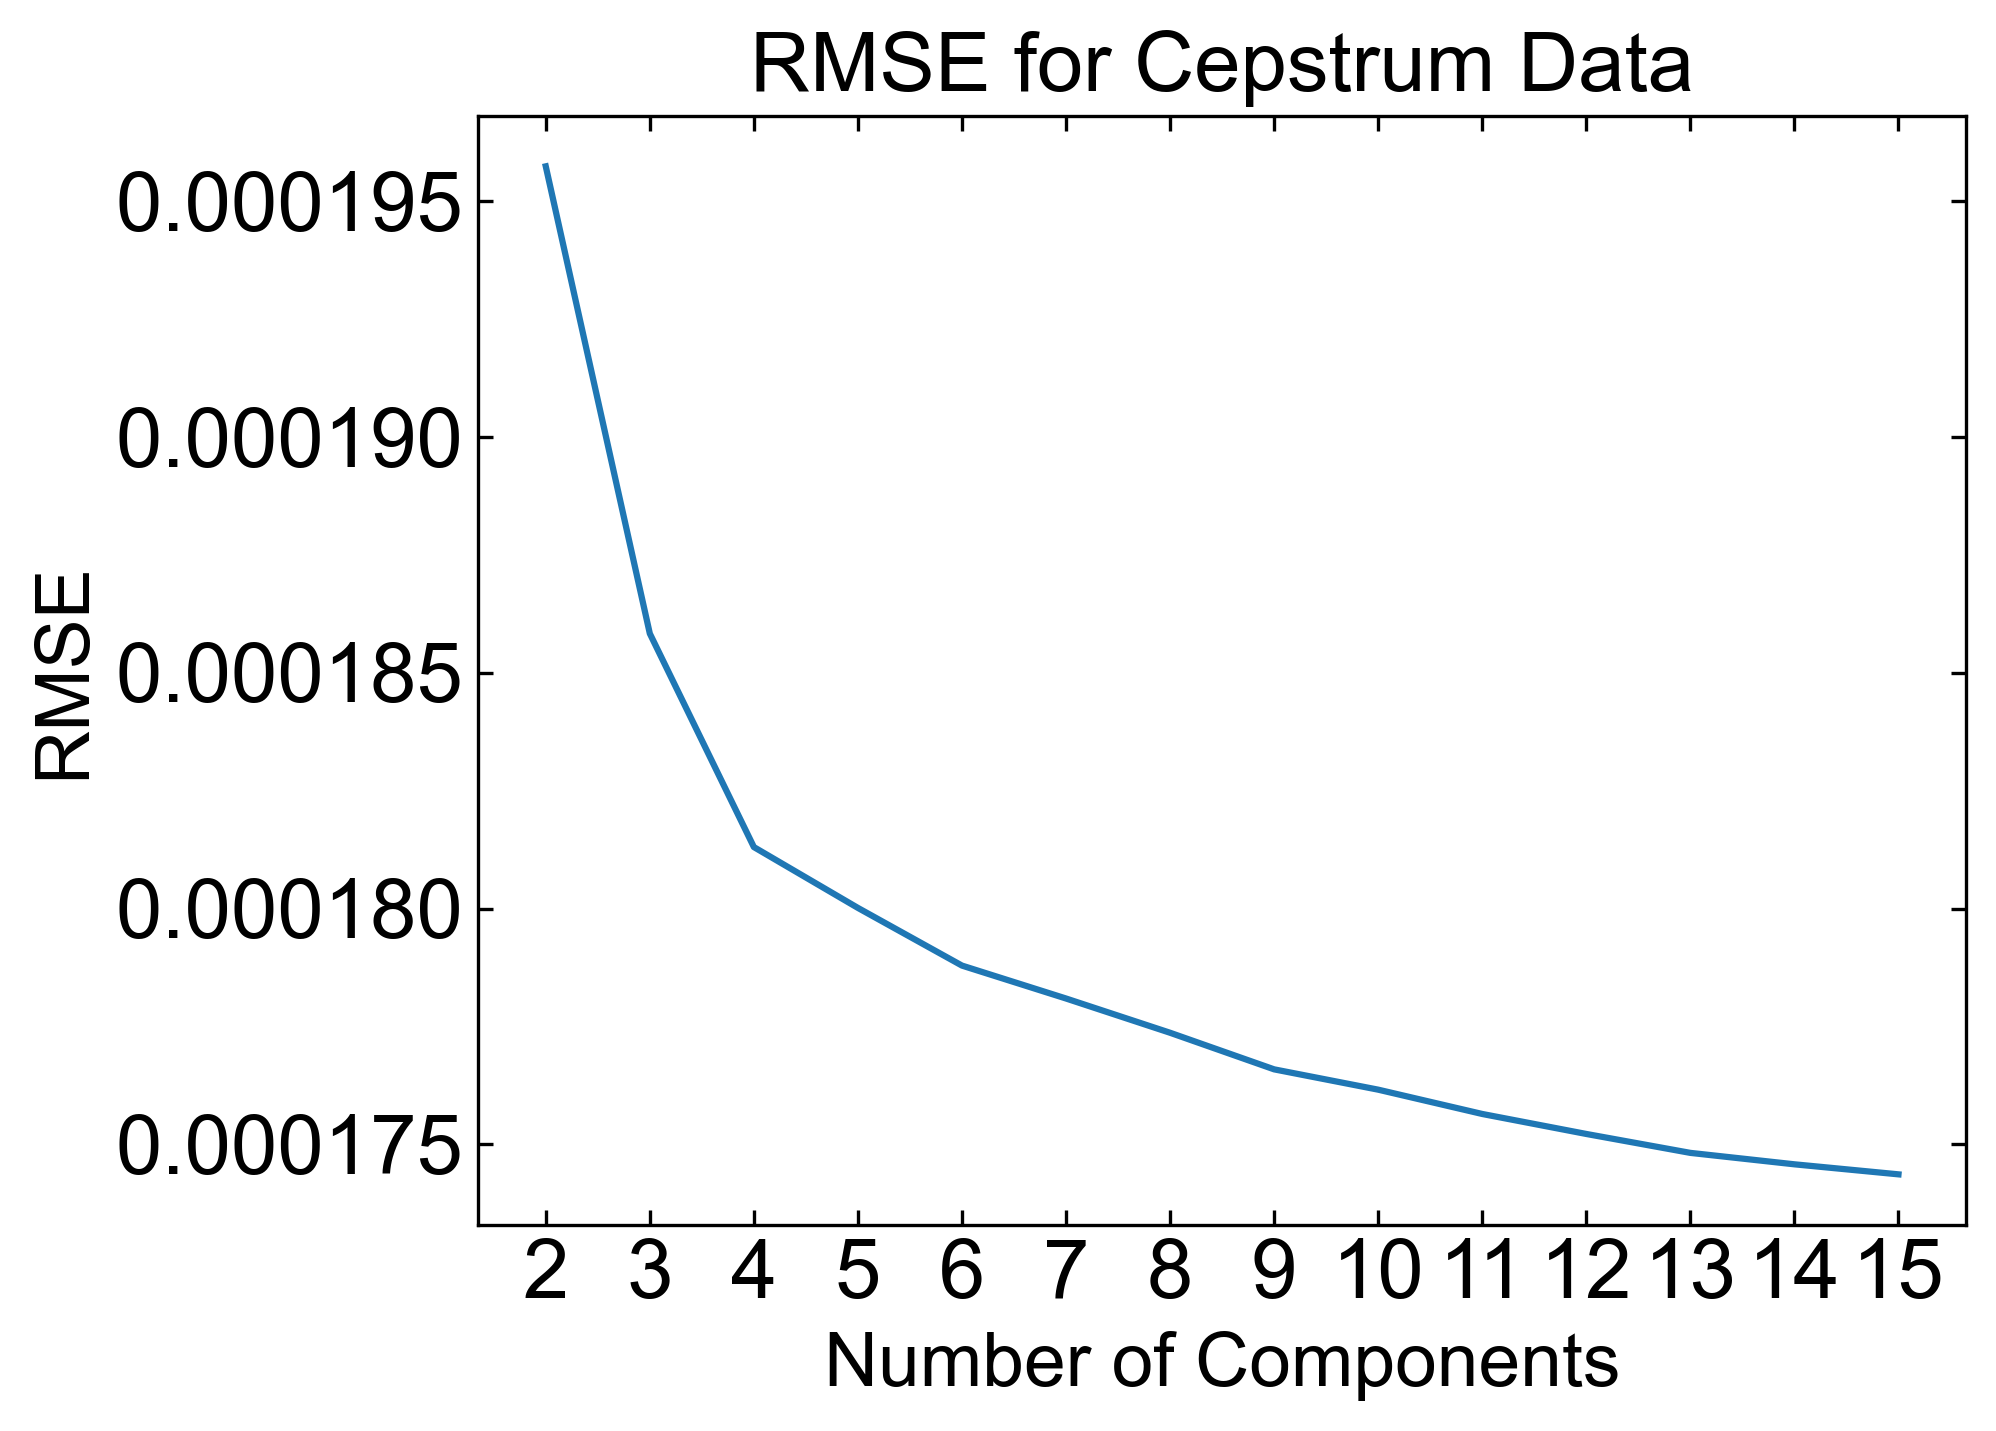

In [64]:
x = np.arange(2,16,1)
fig, ax = plt.subplots(1, 1, dpi = 300)
ax.plot(x, rmse_nmf_cep)
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
plt.title('RMSE for Cepstrum Data', fontsize = 20)
plt.ylabel('RMSE', fontsize = 18)
plt.xlabel('Number of Components', fontsize = 18)
plt.xticks(x,x)

In [55]:
kcn_inertia = []
for i in range(2, 12):
    temp_inertia = []
    for j in range(0,10):
        kmeans_cep_nmf_run = KMeans(n_clusters = i, n_init = 10).fit(sma_cep_nmf[:,:5])
        temp_inertia.append(kmeans_cep_nmf_run.inertia_)
    kcn_inertia.append(np.asarray(temp_inertia).mean())
kcn_inertia = np.asarray(kcn_inertia)

In [56]:
# kcn_inertia = np.asarray(kcn_inertia)
# kcn_inertia.mean()

([<matplotlib.axis.XTick at 0x272372930a0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

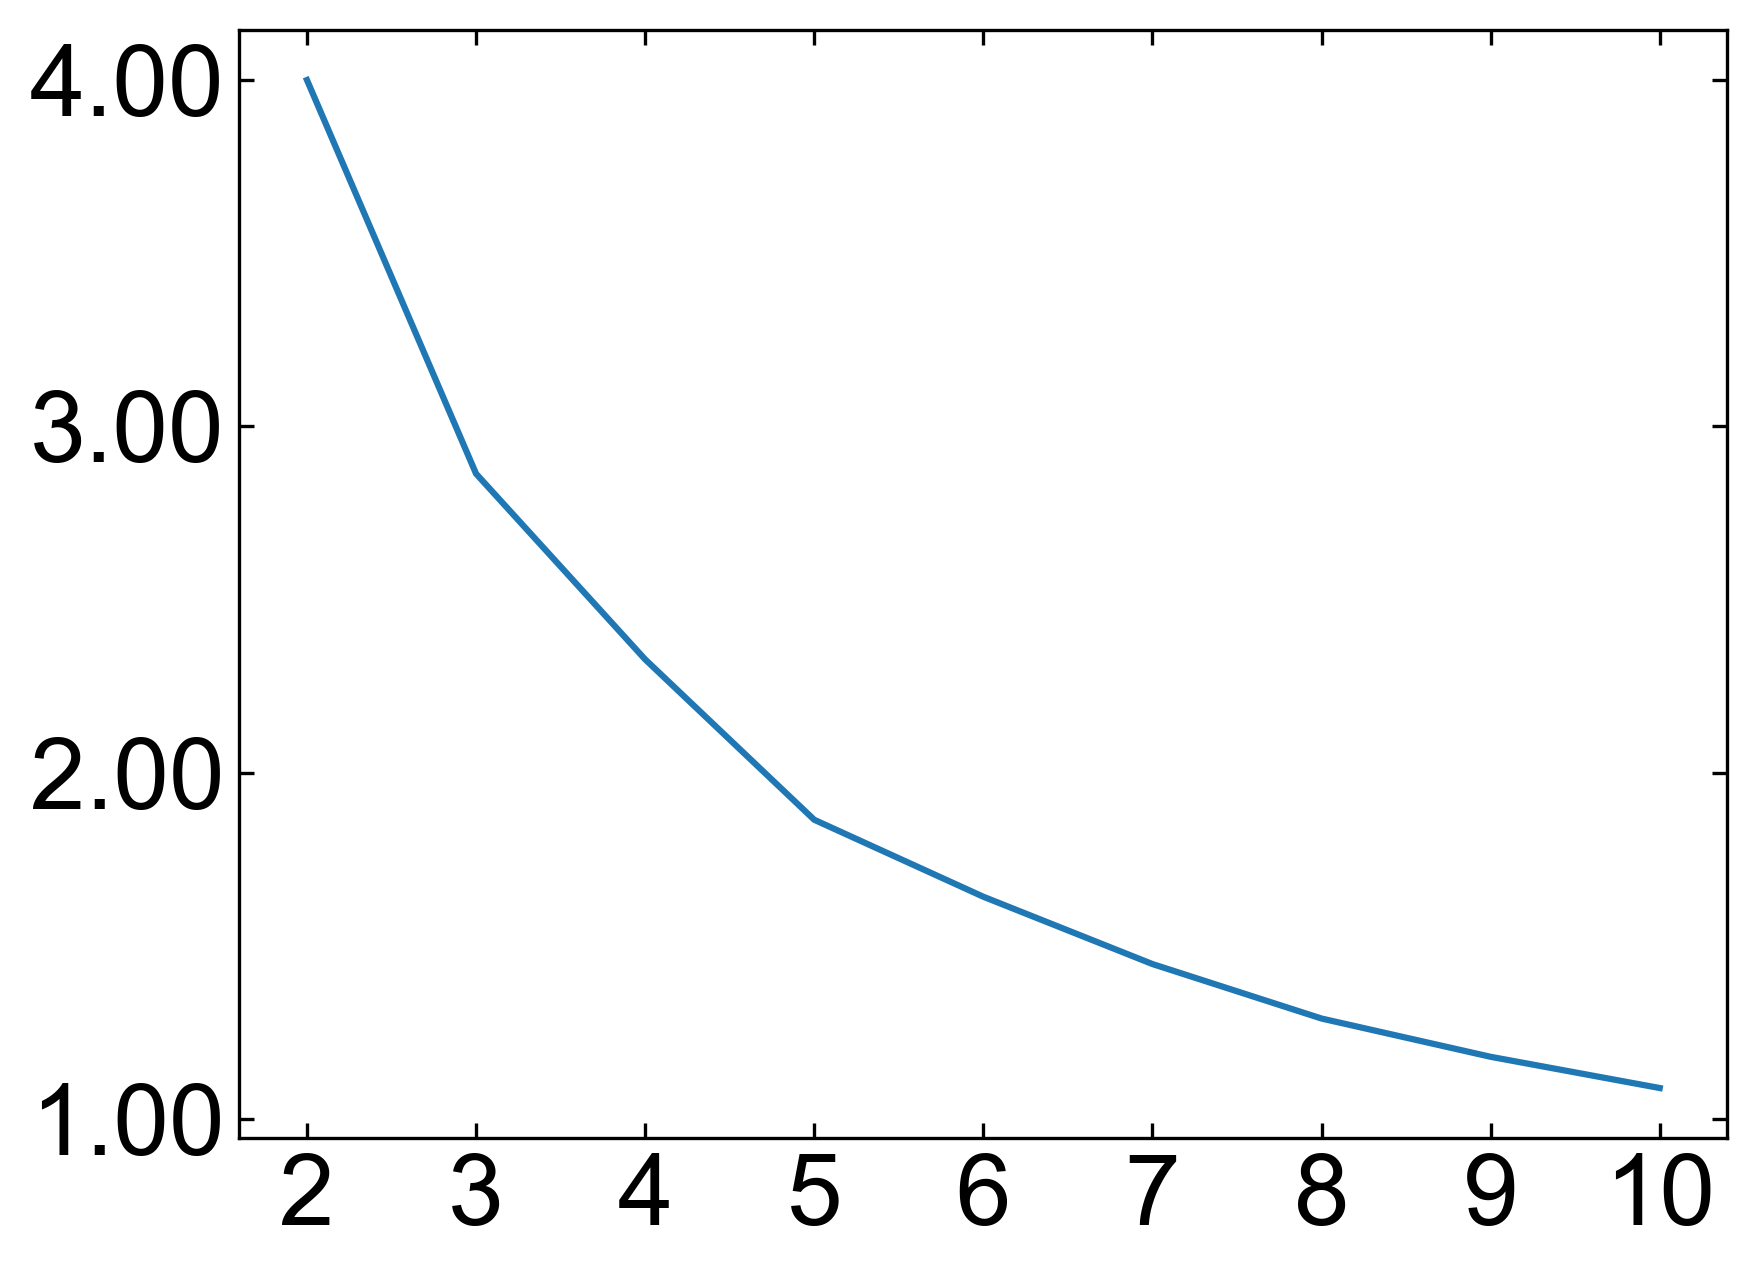

In [266]:
fig, ax = plt.subplots(dpi = 300)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 24)
n = np.arange(2,12,1)
ax.plot(n[0:9], kcn_inertia[0:9])
plt.xticks(n[0:9],n[0:9])

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_12640\1019392672.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_nmf, cmap = cm.get_cmap('RdYlBu', nckn))


(-0.5, 159.5, 409.5, -0.5)

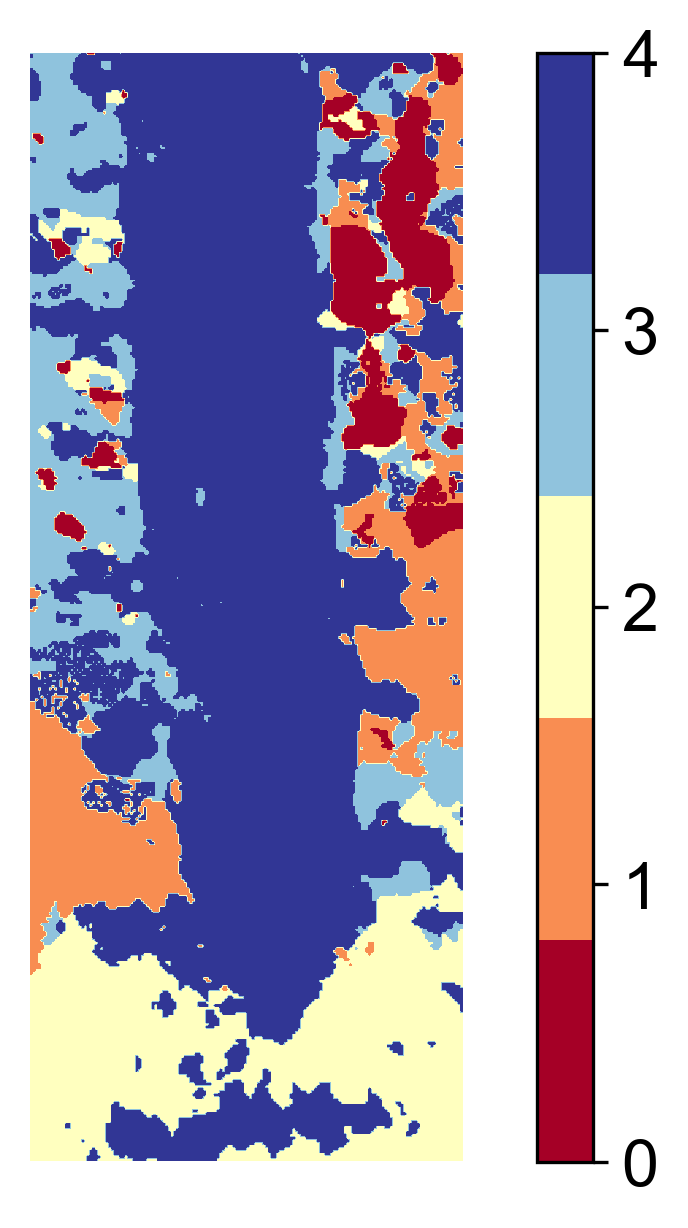

In [89]:
nckn = 5
kmeans_nmf = KMeans(n_clusters = nckn, n_init = 10).fit(sma_nmf[:,:5]) # k = # of clusters

plt.figure(dpi = 300)
cluster_map_nmf = (np.reshape(kmeans_nmf.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_nmf, cmap = cm.get_cmap('RdYlBu', nckn))
plt.colorbar(ticks = np.arange(nckn)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [94]:
nmf_avg_dict = {}
for x in range(nckn):
    nmf_avg_dict["nbed_{0}_avg_nmf".format(x)] = get_avg_dp(kmeans_nmf.labels_, x, sma_nbed_flat.reshape(SET_SIZE, IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 3 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 4 NBED')

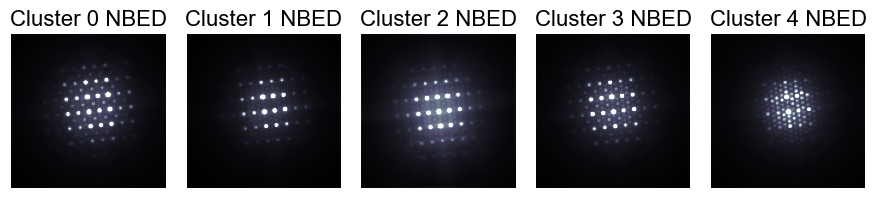

In [105]:
clim_ref = nmf_avg_dict["nbed_2_avg_nmf"]
n_max = clim_ref.mean() + 3*clim_ref.std()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (10, 2))
im1 = ax1.imshow(nmf_avg_dict["nbed_0_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 16)
im2 = ax2.imshow(nmf_avg_dict["nbed_1_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 16)
im3 = ax3.imshow(nmf_avg_dict["nbed_2_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 16)
im4 = ax4.imshow(nmf_avg_dict["nbed_3_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax4.axis('off')
ax4.set_title('Cluster 3 NBED', fontsize = 16)
im5 = ax5.imshow(nmf_avg_dict["nbed_4_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax5.axis('off')
ax5.set_title('Cluster 4 NBED', fontsize = 16)

fig.subplots_adjust(right=1)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_17968\3091390861.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_cep_nmf, cmap = cm.get_cmap('RdYlBu',ncknc))


(-0.5, 159.5, 409.5, -0.5)

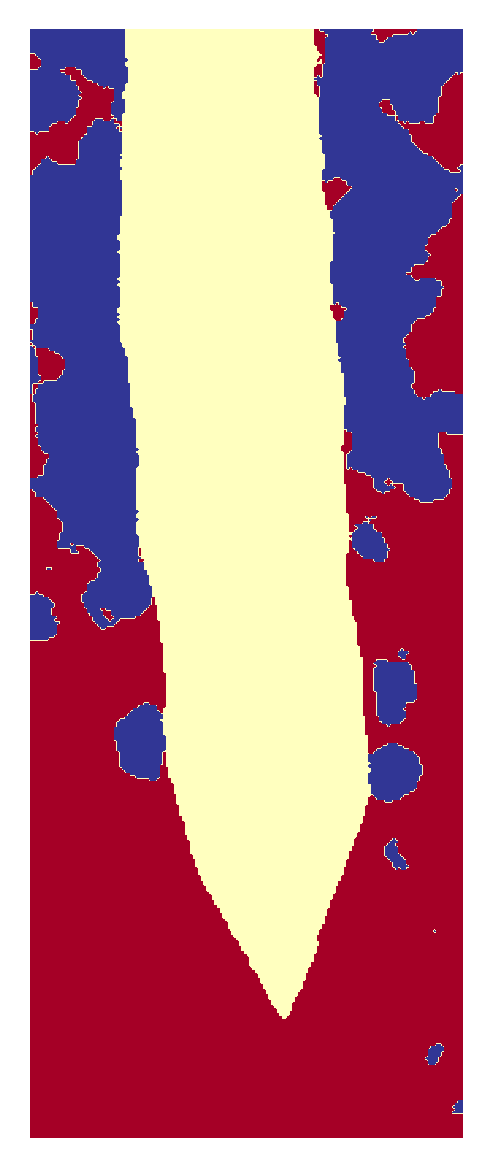

In [55]:
ncknc = 3
kmeans_cep_nmf = KMeans(n_clusters = ncknc, n_init = 10).fit(sma_cep_nmf2[:,:]) # k = # of clusters
plt.figure(dpi = 300)
cluster_map_cep_nmf = (np.reshape(kmeans_cep_nmf.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_cep_nmf, cmap = cm.get_cmap('RdYlBu',ncknc))
#plt.colorbar(ticks = np.arange(ncknc)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [10]:
cep_nmf_avg_dict = {}
nmf_avg_dict = {}
for x in range(ncknc):
    cep_nmf_avg_dict["nbed_{0}_avg_cep_nmf".format(x)] = get_avg_dp(kmeans_cep_nmf.labels_, x, sma_cep_im)
for x in range(ncknc):
    nmf_avg_dict["nbed_{0}_avg_nmf".format(x)] = get_avg_dp(kmeans_cep_nmf.labels_, x, sma_nbed)

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

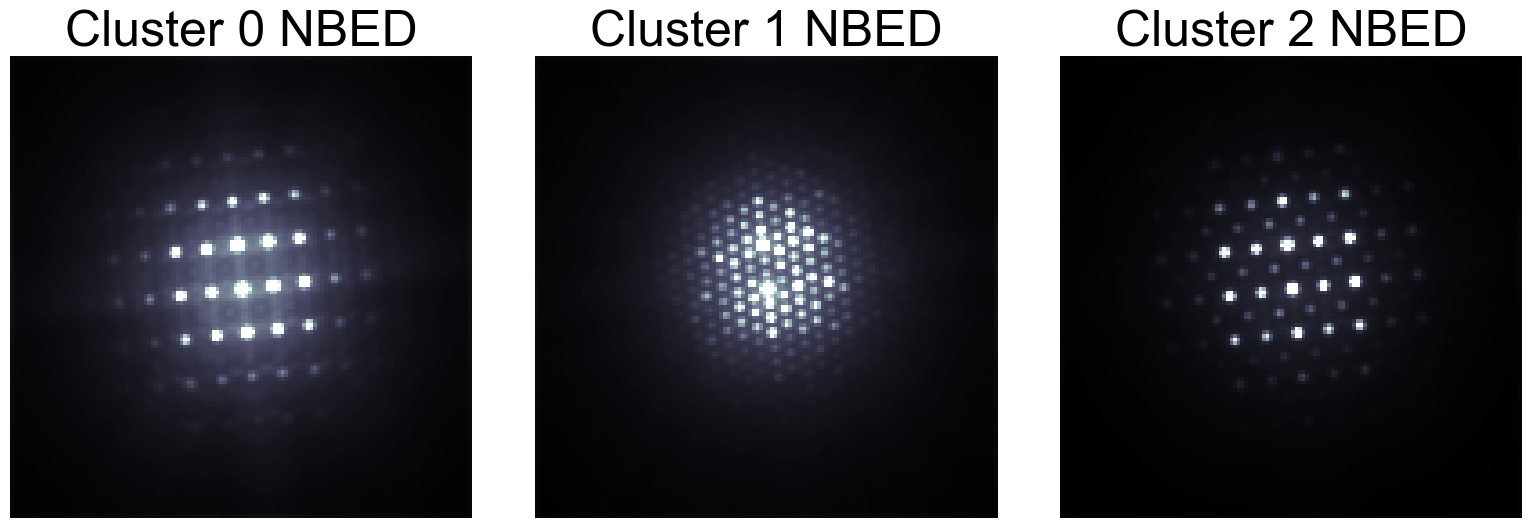

In [11]:
clim_ref2 = nmf_avg_dict["nbed_1_avg_nmf"]
n_max = clim_ref2.mean() + 3*clim_ref2.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))
im1 = ax1.imshow(nmf_avg_dict["nbed_0_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 36)
im2 = ax2.imshow(nmf_avg_dict["nbed_1_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 36)
im3 = ax3.imshow(nmf_avg_dict["nbed_2_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 36)
# im4 = ax4.imshow(nmf_avg_dict["nbed_3_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax4.axis('off')
# ax4.set_title('Cluster 3 NBED', fontsize = 36)
# im5 = ax5.imshow(nmf_avg_dict["nbed_4_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax5.axis('off')
# ax5.set_title('Cluster 4 NBED', fontsize = 36)
# im6 = ax6.imshow(nmf_avg_dict["nbed_5_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax6.axis('off')
# ax6.set_title('Cluster 5 NBED', fontsize = 36)

fig.subplots_adjust(right=1)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 Cepstrum')

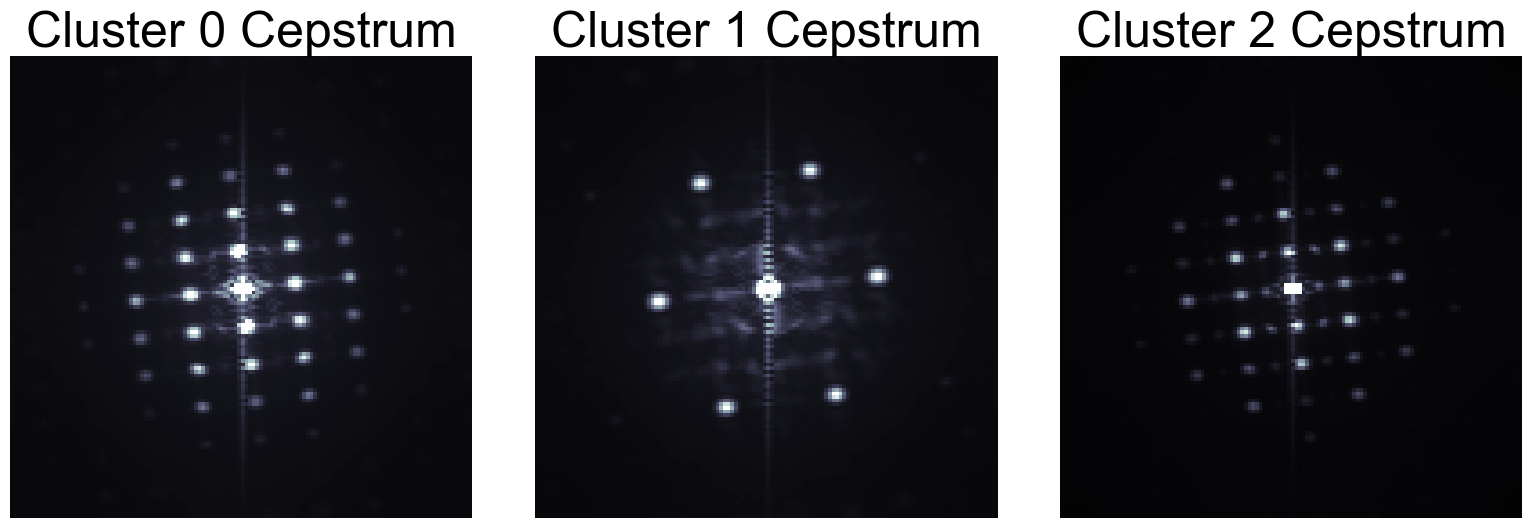

In [18]:
clim_ref = cep_nmf_avg_dict["nbed_2_avg_cep_nmf"]
c_max = clim_ref.mean() + 1*clim_ref.std()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))
im1 = ax1.imshow(cep_nmf_avg_dict["nbed_0_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax1.axis('off')
ax1.set_title('Cluster 0 Cepstrum', fontsize = 36)
im2 = ax2.imshow(cep_nmf_avg_dict["nbed_1_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax2.axis('off')
ax2.set_title('Cluster 1 Cepstrum', fontsize = 36)
im3 = ax3.imshow(cep_nmf_avg_dict["nbed_2_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax3.axis('off')
ax3.set_title('Cluster 2 Cepstrum', fontsize = 36)
# im4 = ax4.imshow(cep_nmf_avg_dict["nbed_3_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
# ax4.axis('off')
# ax4.set_title('Cluster 3 Cepstrum', fontsize = 36)
# im5 = ax5.imshow(cep_nmf_avg_dict["nbed_4_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax5.axis('off')
# ax5.set_title('Cluster 4 Cepstrum', fontsize = 36)
# im6 = ax6.imshow(cep_nmf_avg_dict["nbed_5_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax6.axis('off')
# ax6.set_title('Cluster 5 Cepstrum', fontsize = 36)

fig.subplots_adjust(right=1, wspace = None, hspace = None)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 36)
plt.subplots_adjust(wspace=0)
plt.show()

## Getting reconstructed NBED patterns from NMF decomposition

In [22]:
sma_nmf_rec = (nmf.inverse_transform(sma_nmf)).reshape(sma_nmf.shape[0], IMG_SIZE, IMG_SIZE)

In [21]:
sma_cep_nmf_rec = (nmf2.inverse_transform(sma_cep_nmf)).reshape(sma_nmf.shape[0], IMG_SIZE, IMG_SIZE)
np.save('smaGacepnmfrecWhole-160x410', sma_cep_nmf_rec)

In [7]:
sma_cep_nmf_rec = np.load('smaGacepnmfrecWhole-160x410.npy')
sma_cep_nmf_rec.shape

(65600, 128, 128)

(-0.5, 127.5, 127.5, -0.5)

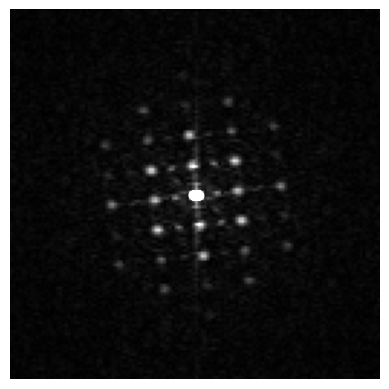

In [12]:
plt.imshow(sma_cep_im[3000], cmap = 'gray')
plt.axis('off')
plt.clim([0, sma_cep_im[3000].mean() + 1*sma_cep_im[3000].std()])

(-0.5, 127.5, 127.5, -0.5)

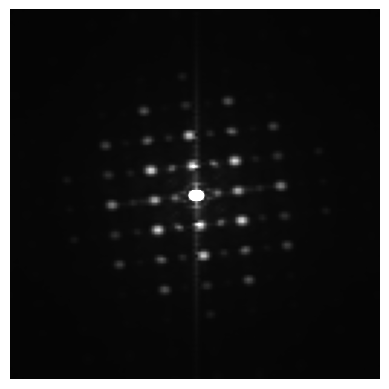

In [14]:
plt.imshow(sma_cep_nmf_rec[3000], cmap = 'gray')
plt.axis('off')
plt.clim([0, sma_cep_nmf_rec[3000].mean() + 1*sma_cep_nmf_rec[3000].std()])

## Virtual Dark-Field from NBED Spots

<Figure size 1000x1000 with 0 Axes>

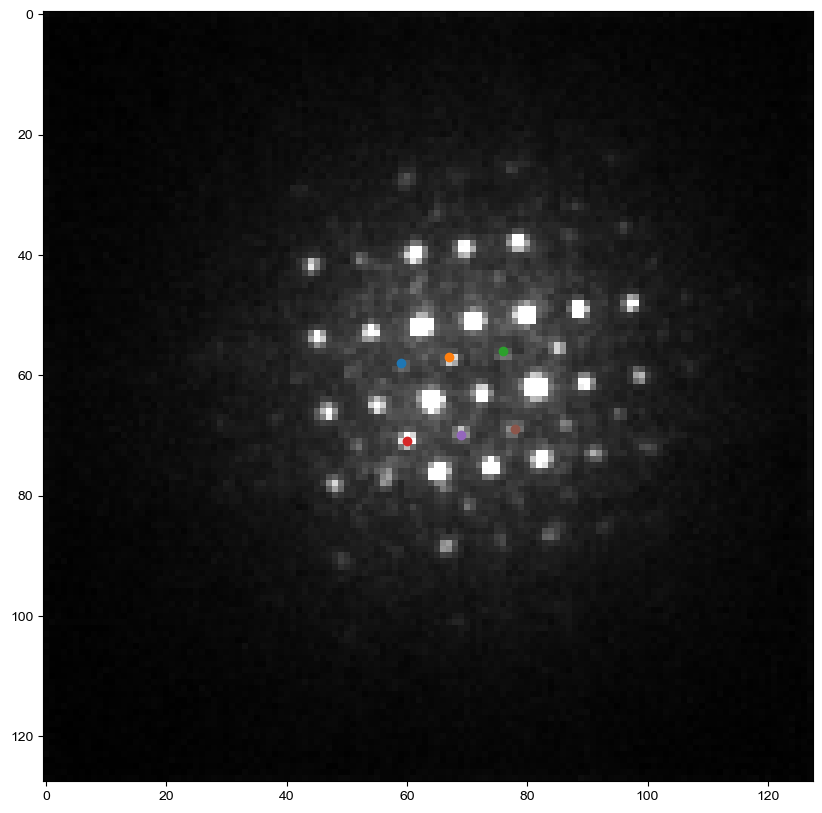

In [251]:
nbed = sma_nbed[3000]
plt.figure(figsize = (10,10))
plt.imshow(nbed, cmap = 'gray')
plt.clim([0, nbed.mean() + 3*nbed.std()])
y1, x1 = 58, 59
y2, x2 = 57, 67
y3, x3 = 56, 76
y4, x4 = 71, 60
y5, x5 = 70, 69
y6, x6 = 69, 78
plt.plot(x1, y1, 'o')
plt.plot(x2, y2, 'o')
plt.plot(x3, y3, 'o')
plt.plot(x4, y4, 'o')
plt.plot(x5, y5, 'o')
plt.plot(x6, y6, 'o')

heusler_spots = [(y1,x1), (y2,x2), (y3,x3), (y4,x4), (y5,x5), (y6,x6)]

In [245]:
vdf_map1 = []
r = 3
for i in range(len(sma_nbed)):
    curr_cep = sma_nbed[i]
    single_dp_int = []
    for j in range(len(heusler_spots)):
        yy, xx = heusler_spots[j]
        spot_int = (highest(curr_cep[yy - r: yy + r, xx - r: xx + r].ravel(),20)).sum()
        single_dp_int.append(spot_int)
    vdf_map1.append((np.asarray(single_dp_int)).sum())

In [246]:
vdf_map1 = (np.asarray(vdf_map1)).reshape(ScanX, ScanY)

<Figure size 800x800 with 0 Axes>

(-0.5, 159.5, 409.5, -0.5)

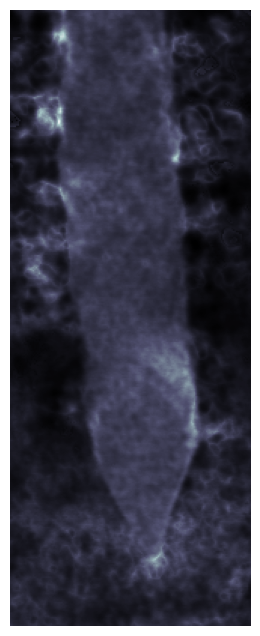

In [247]:
plt.figure(figsize = (8,8))
plt.imshow(vdf_map1, cmap = 'bone')
plt.axis('off')
#plt.title('Virtual Dark-Field Image with Heusler Spots', fontsize = 16)
#plt.colorbar(fraction = 0.04)

## "Virtual Dark-Field" Image from Cepstrum Spots

<Figure size 1000x1000 with 0 Axes>

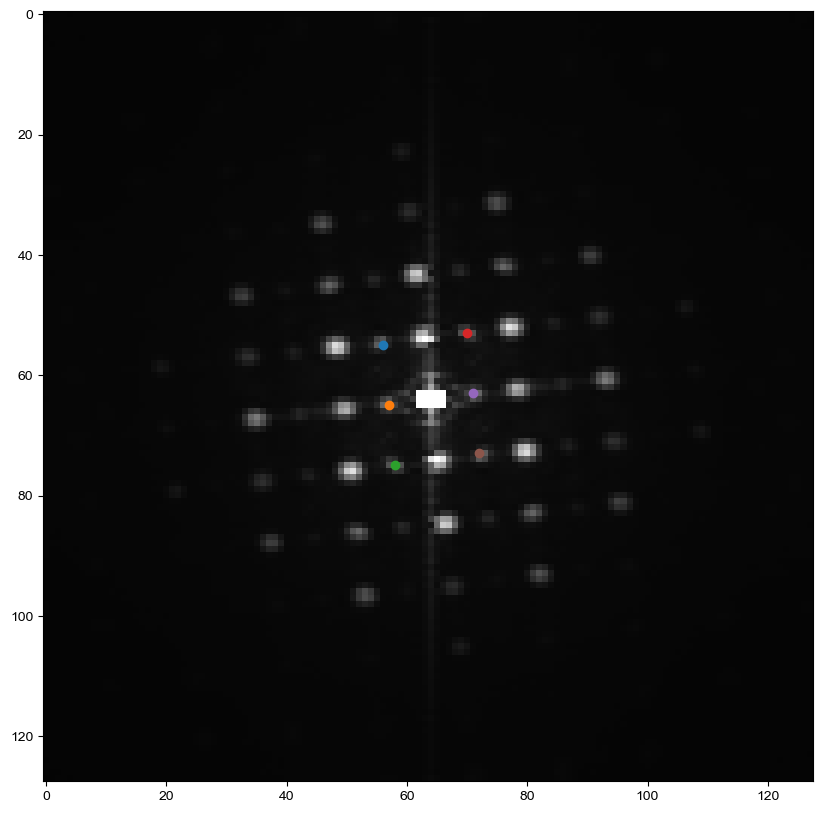

In [36]:
Cep = sma_cep_nmf_rec[3000]
plt.figure(figsize = (10,10))
plt.imshow(Cep, cmap = 'gray')
plt.clim([0, Cep.mean() + 1*Cep.std()])
y1, x1 = 55, 56
y2, x2 = 65, 57
y3, x3 = 75, 58
y4, x4 = 53, 70
y5, x5 = 63, 71
y6, x6 = 73, 72
plt.plot(x1, y1, 'o')
plt.plot(x2, y2, 'o')
plt.plot(x3, y3, 'o')
plt.plot(x4, y4, 'o')
plt.plot(x5, y5, 'o')
plt.plot(x6, y6, 'o')

heusler_spots = [(y1,x1), (y2,x2), (y3,x3), (y4,x4), (y5,x5), (y6,x6)]

In [38]:
vdf_map = []
r = 3
for i in range(len(sma_cep_nmf_rec)):
    curr_cep = sma_cep_nmf_rec[i]
    single_dp_int = []
    for j in range(len(heusler_spots)):
        yy, xx = heusler_spots[j]
        spot_int = (highest(curr_cep[yy - r: yy + r, xx - r: xx + r].ravel(),16)).sum()
        single_dp_int.append(spot_int)
    vdf_map.append((np.asarray(single_dp_int)).sum())

In [39]:
vdf_map = (np.asarray(vdf_map)).reshape(ScanX, ScanY)

<Figure size 800x800 with 0 Axes>

(-0.5, 159.5, 409.5, -0.5)

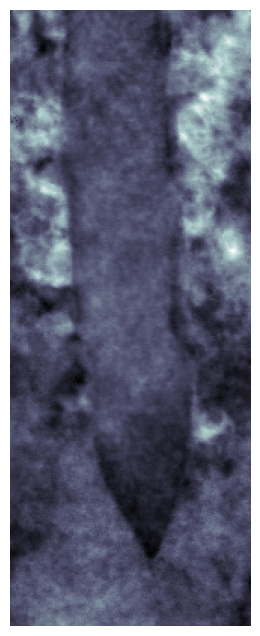

In [252]:
plt.figure(figsize = (8,8))
plt.imshow(vdf_map, cmap = 'bone')
plt.axis('off')
#plt.title('"Virtual Dark-Field Cepstrum Image" with Heusler Spots', fontsize = 16)
#plt.colorbar(fraction = 0.04)

## Strain Mapping

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

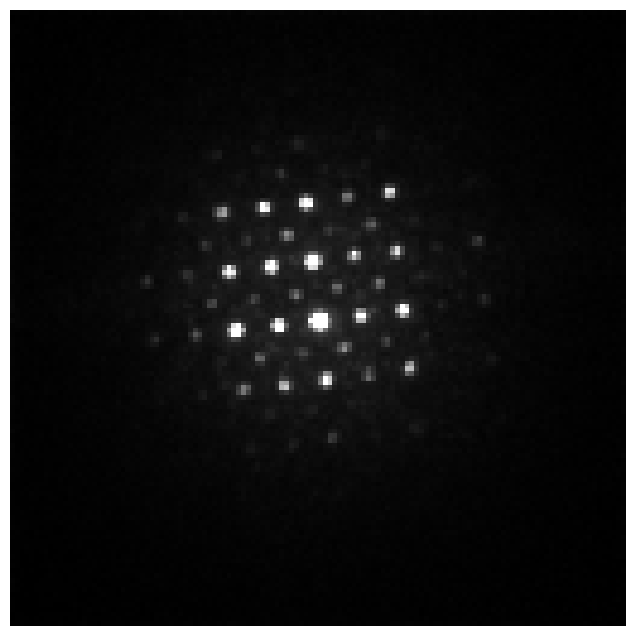

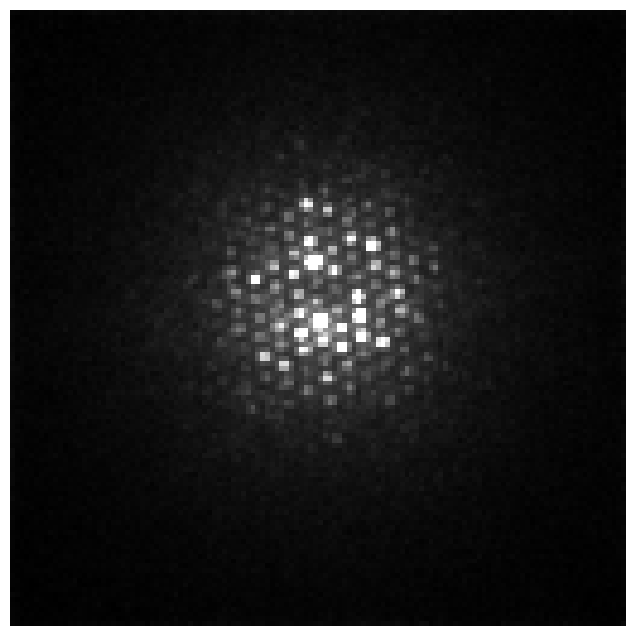

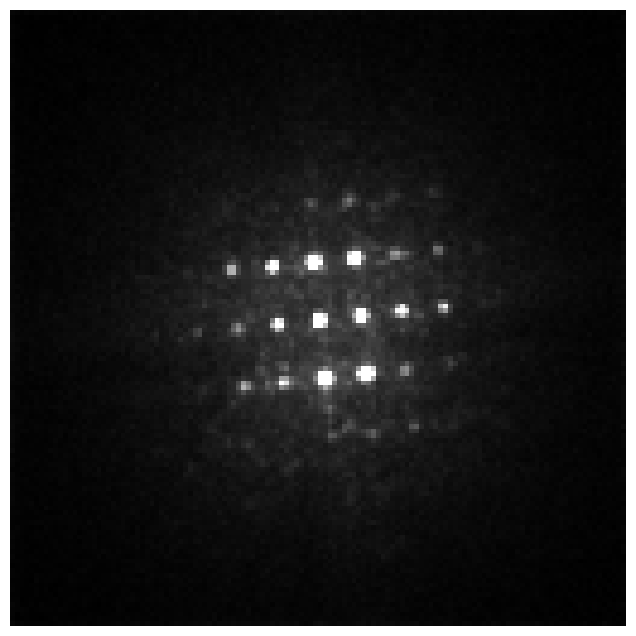

In [11]:
for i in (1623, 5000, 60000):
    Cep = sma_nbed[i]

    plt.figure(figsize=(8,8)) # why small? why rotated?
    plt.imshow(Cep, cmap = 'gray')
    #plt.colorbar(fraction = 0.03, pad = 0.02)
    plt.axis('off')
    plt.clim([0, Cep.mean() + 5*Cep.std()])

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

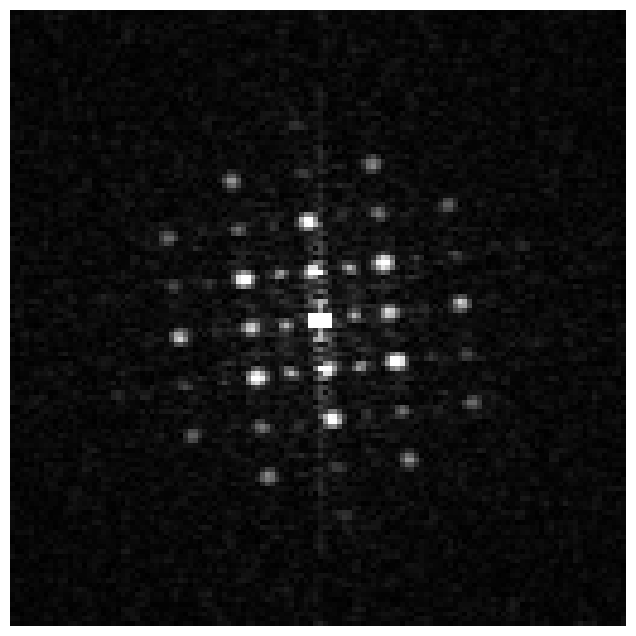

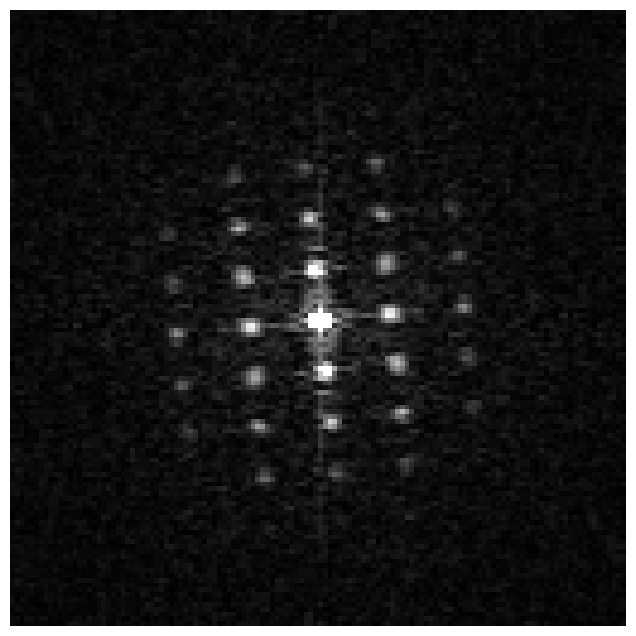

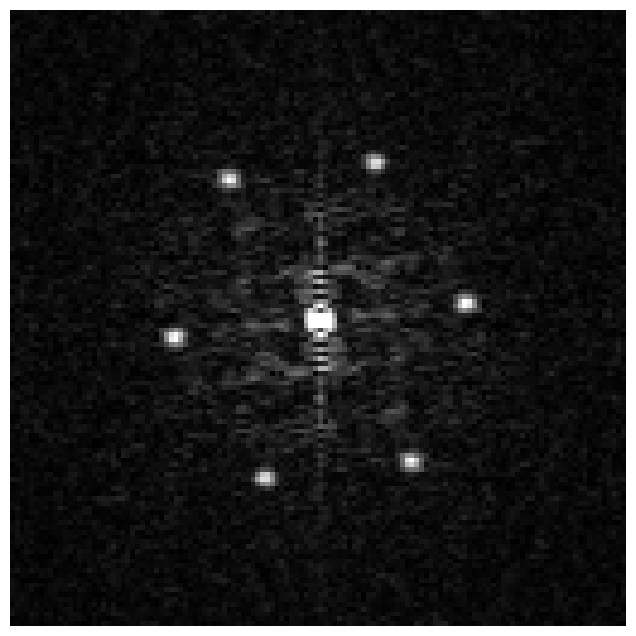

In [23]:
for i in (1623, 60000, 5000):
    Cep = sma_cep_im[i]

    plt.figure(figsize=(8,8)) # why small? why rotated?
    plt.imshow(Cep, cmap = 'gray')
    #plt.colorbar(fraction = 0.03, pad = 0.02)
    plt.axis('off')
    plt.clim([0, Cep.mean() + 0.6*Cep.std()])


<Figure size 1200x1200 with 0 Axes>

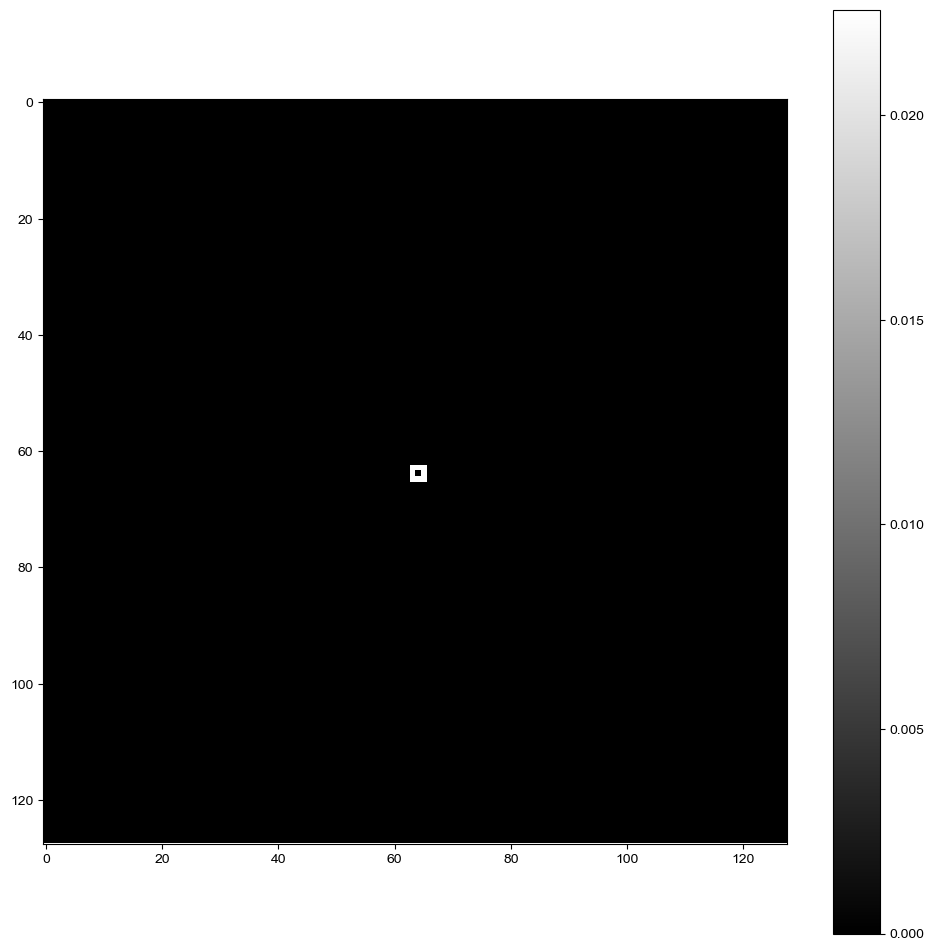

In [24]:
sob = canny(Cep, sigma = 1)#, low_threshold = 10, high_threshold = 20)
plt.figure(figsize = (12,12))
plt.imshow(sob, cmap = 'gray')
plt.colorbar()
plt.clim([0, sob.mean() + 1*sob.std()])

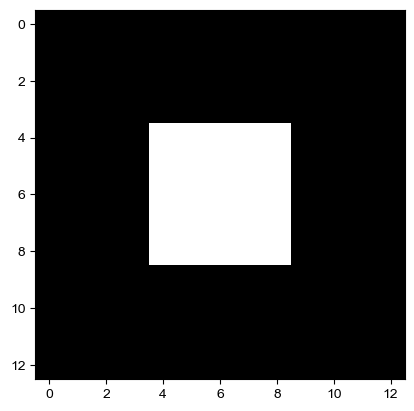

In [25]:
template = np.zeros((13,13))
r = 3
[aa,bb] = ellipse(6 ,6 , r, r)
template[aa,bb] = .005
plt.imshow(template, cmap = 'gray')

(6, 2)

<Figure size 1200x1200 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

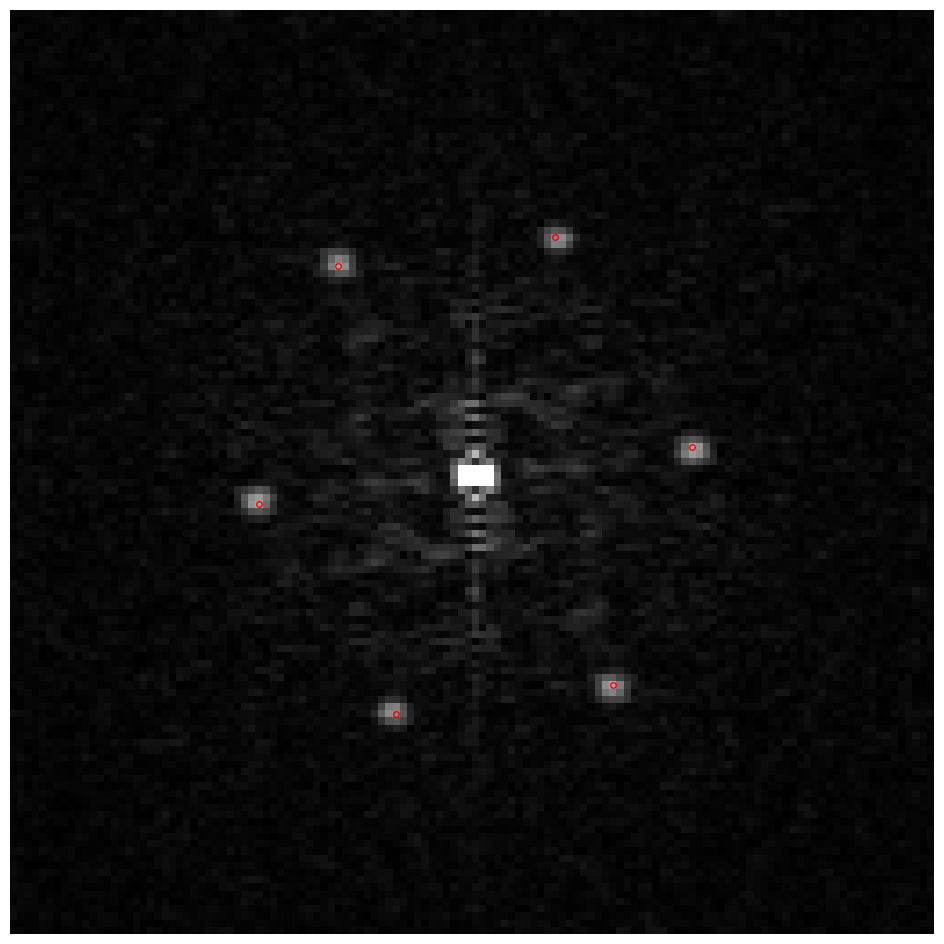

In [26]:
min_distance = 2*r
th = 0.7
match = match_template(Cep, template, pad_input = True)
peaks = peak_local_max(match,min_distance=min_distance,threshold_rel=th)
peaks.shape
plt.figure(figsize=(12,12))
plt.imshow(Cep, cmap = 'gray')
plt.clim([0, Cep.mean() + 1*Cep.std()])
plt.axis('off')
plt.plot(peaks[:,1], peaks[:,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=4)

<Figure size 1200x1200 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

Text(42, 32, '0')

Text(80, 90, '1')

Text(31, 65, '2')

Text(91, 57, '3')

Text(72, 28, '4')

Text(50, 94, '5')

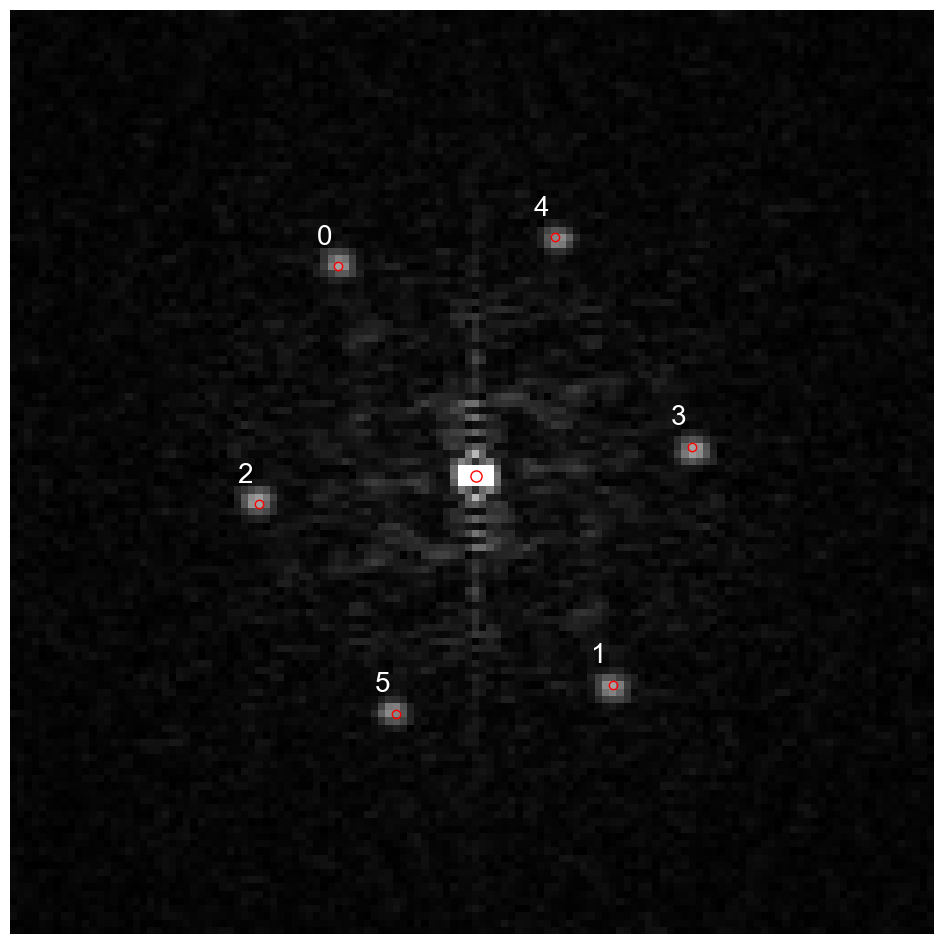

In [27]:
plt.figure(figsize=(12,12))
plt.imshow(Cep, cmap = 'gray')
plt.clim([0, Cep.mean() + 1*Cep.std()])
plt.axis('off')
plt.plot(64, 64, 'o', markeredgecolor = 'r', markerfacecolor = 'none', markersize = 8)
for i in range(len(peaks)):
    plt.plot(peaks[i,1], peaks[i,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=6)
    plt.annotate((str(i)), xy = (peaks[i,1] - 3, peaks[i,0] - 3), color = 'white', fontsize = 20)

# Usage of Gaussian Peak Fitting for Strain Mapping

In [15]:
def get_gauss(grid, region, initials):
    a, b = opt.curve_fit(GaussSingle, grid, region, p0 = initials)
    return a, b

In [16]:
def get_basis(dataset, peak_pairs, radius, rough_peaks):
    dataset = dataset # probably a nmf decomposed --> recovered array of cepstrums
    peak_pairs = peak_pairs # the list of 2 peaks from cross-correlation map
    rough_peaks = rough_peaks # list of peak positions (rough position estimates for Gaussian fiing)
    rr = radius # should be same as radius of ring template
    cent = dataset.shape[1]//2 # geing center coordinate of image to approximate center spot position
    au = []
    bv = []
    for i in range(len(dataset)):
        Ceps = dataset[i]
        w = h = 2*rr
        x = np.linspace(cent - 2*rr, cent + 2*rr , 2*(w)) 
        y = np.linspace(cent - 2*rr , cent + 2*rr , 2*(h))
        xydata0 = np.meshgrid(x, y)
        bg_guess0 = np.mean(lowest(Ceps[cent - 2*rr: cent + 2*rr, cent - 2*rr: cent + 2*rr].ravel(),8))
        amp_guess0 = np.mean(highest(Ceps[cent - 2*rr: cent + 2*rr, cent - 2*rr: cent + 2*rr].ravel(),8))
        xguess0 = cent
        yguess0 = cent
        init_guess0 = (amp_guess0, xguess0, yguess0, rr, rr, bg_guess0) 
        popt0, pcov0 = get_gauss(xydata0, Ceps[cent - 2*rr : cent + 2*rr , cent - 2*rr : cent + 2*rr ].ravel(), init_guess0)
        count = 0
        for pp in peak_pairs:
            x = np.linspace(rough_peaks[pp,1] - 2*rr , rough_peaks[pp,1] + 2*rr , 2*(w)) 
            y = np.linspace(rough_peaks[pp,0] - 2*rr , rough_peaks[pp,0] + 2*rr , 2*(h))
            xydata = np.meshgrid(x, y)
            bg_guess = np.mean(lowest(Ceps[rough_peaks[pp,0] - 2*rr: rough_peaks[pp,0] + 2*rr, rough_peaks[pp,1] - 2*rr: rough_peaks[pp,1] + 2*rr].ravel(),5))
            amp_guess = np.mean(highest(Ceps[rough_peaks[pp,0] - 2*rr: rough_peaks[pp,0] + 2*rr, rough_peaks[pp,1] - 2*rr: rough_peaks[pp,1] + 2*rr].ravel(),5))
            xguess = rough_peaks[pp,1]
            yguess = rough_peaks[pp,0]
            init_guess = (amp_guess, xguess, yguess, 2.5, 2.5, bg_guess)    
            try:
                popt, pcov = get_gauss(xydata, Ceps[rough_peaks[pp,0] - 2*rr : rough_peaks[pp,0] + 2*rr , rough_peaks[pp,1] - 2*rr : rough_peaks[pp,1] + 2*rr ].ravel(), init_guess)
            except:
                print(i,pp)
            vect = np.array([popt[1] - popt0[1], popt[2] - popt0[2]]) # vector 1 for first peak in x,y
            if count == 0:
                au.append(vect)
            elif count == 1:
                bv.append(vect)
            count += 1
    return np.asarray(au), np.asarray(bv)
        

In [17]:
unfit_u1, unfit_v1 = get_basis(sma_cep_nmf_rec, [5,2], 3, peaks)
unfit_u2, unfit_v2 = get_basis(sma_cep_nmf_rec, [4,3], 3, peaks)
#unfit_v3, unfit_v4 = get_basis(sma_cep_nmf_rec, [1,2], 3, peaks)

In [18]:
# i = 1962
# im = sma_cep_nmf_rec[i]
# plt.figure(figsize = (8,8))
# plt.imshow(im)
# plt.clim([0, im.mean() + im.std()])
# plt.plot(peaks[:,1], peaks[:,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=4)

# temp_p = [4,0,5,1]
# tt = 0
# rr = 4
# for pp in temp_p:
#     plt.figure()
#     plt.imshow(im[peaks[pp,0] - 2*rr+ tt: peaks[pp,0] + 2*rr+ tt, peaks[pp,1] - 2*rr+ tt: peaks[pp,1] + 2*rr+ tt])

In [19]:
unfit_u = ((unfit_u1) - (unfit_u2)) # do not divide by 2 bc need to account for actual Y-dir component first
unfit_u
unfit_v = ((unfit_v1) - (unfit_v2))/2
# unfit_v[:,0] = unfit_v[:,0] - unfit_v3[:,0] + unfit_v4[:,0]
# unfit_v[:,1] = unfit_v[:,1] + unfit_v3[:,1] - unfit_v4[:,1]
# unfit_v = unfit_v/4
unfit_v

array([[-21.74014602,  65.05828095],
       [-21.82137033,  65.05891405],
       [-21.87921368,  65.11271011],
       ...,
       [-21.81579807,  65.46662461],
       [-21.88996401,  65.49340116],
       [-21.95375536,  65.4078886 ]])

array([[-29.05162142,   3.38428549],
       [-29.04214524,   3.43081486],
       [-29.05306055,   3.44658521],
       ...,
       [-29.34583065,   3.26640656],
       [-29.30766224,   3.29291653],
       [-29.26570068,   3.27555891]])

In [ ]:
np.save("unfit_u_whole", unfit_u)
np.save("unfit_v_whole", unfit_v)

In [32]:
unfit_u = np.load("unfit_u_whole.npy")
unfit_v = np.load("unfit_v_whole.npy")

In [33]:
unfit_u.shape
unfit_v.shape

(65600, 2)

(65600, 2)

# Defining Kernel to convolve around the scan region so that we only select cluster points away from interfaces to create the reference structure

In [34]:
kernel = np.ones((11,11))

In [35]:
kernel

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

(-0.5, 159.5, 409.5, -0.5)

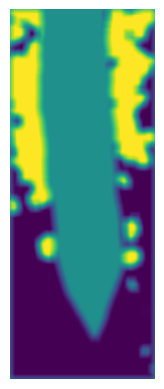

In [45]:
find_mat = signal.convolve2d(cluster_map_cep_nmf, kernel, mode = 'same', fillvalue = 1)
plt.imshow(np.abs(find_mat))
plt.axis('off')
#plt.colorbar()

In [46]:
find_mat.shape

(410, 160)

In [47]:
matrix_pts = np.asarray(np.where(np.abs(find_mat.ravel()) == 0)).T
matrix_pts.shape
#ss = np.random.permutation(matrix_pts.shape[0])

(16093, 1)

In [48]:
mat_pts_4_ref = np.atleast_2d(matrix_pts[-640:])
mat_pts_4_ref.shape
fullprint(mat_pts_4_ref)

(640, 1)

array([[64095],
       [64096],
       [64097],
       [64098],
       [64099],
       [64100],
       [64101],
       [64102],
       [64103],
       [64104],
       [64105],
       [64106],
       [64107],
       [64108],
       [64109],
       [64110],
       [64111],
       [64112],
       [64113],
       [64114],
       [64115],
       [64116],
       [64117],
       [64118],
       [64119],
       [64120],
       [64121],
       [64122],
       [64123],
       [64124],
       [64125],
       [64126],
       [64127],
       [64128],
       [64129],
       [64130],
       [64131],
       [64132],
       [64133],
       [64134],
       [64135],
       [64136],
       [64137],
       [64138],
       [64139],
       [64140],
       [64141],
       [64142],
       [64143],
       [64144],
       [64145],
       [64146],
       [64147],
       [64148],
       [64149],
       [64150],
       [64165],
       [64166],
       [64167],
       [64168],
       [64169],
       [64170],
       [

# Peak Pairs calculation

In [49]:
basis_ax = unfit_u[mat_pts_4_ref][:,0][:,0].mean()
basis_ay = unfit_u[mat_pts_4_ref][:,0][:,1].mean()
basis_bx = unfit_v[mat_pts_4_ref][:,0][:,0].mean()
basis_by = unfit_v[mat_pts_4_ref][:,0][:,1].mean()
basis_ax
basis_ay
basis_bx
basis_by

-22.72816161251226

65.5318753166465

-29.654746003917193

3.1178461830357564

In [50]:
real_u = unfit_u - [basis_ax, basis_ay]
real_v = unfit_v - [basis_bx, basis_by]

In [51]:
uvx = np.vstack((real_u[:,0], real_v[:,0]))

uvy = np.vstack((real_u[:,1], real_v[:,1]))

In [52]:
uvx.shape

(2, 65600)

In [53]:
mat_A = np.array([[basis_ax, basis_ay],[basis_bx, basis_by]])
mat_A.shape
mat_A

(2, 2)

array([[-22.72816161,  65.53187532],
       [-29.654746  ,   3.11784618]])

In [54]:
Ey = np.matmul(np.linalg.inv(mat_A), uvy)
Ex = np.matmul(np.linalg.inv(mat_A), uvx)
Ey.shape
Ex.shape

(2, 65600)

(2, 65600)

In [55]:
eps_xx = Ex[0].reshape(ScanX, ScanY) # based on equation in peak pairs paper
eps_yy = Ey[1].reshape(ScanX, ScanY)
eps_xy = Ex[1].reshape(ScanX, ScanY)
eps_yx = Ey[0].reshape(ScanX, ScanY)

In [56]:
# Precision measurements from a 25x25 region in bottom left corner
eps_xx[385:410, 25:50].mean()
eps_xx[385:410, 25:50].std()
eps_yy[385:410, 25:50].mean()
eps_yy[385:410, 25:50].std()

-0.0004522890914384948

0.0019782123957566423

-0.0006300500996278544

0.0017187570260775087

In [58]:
min1 = np.abs(np.array([Ey, Ex]).min())
max1 = np.array([Ey, Ex]).max()
min1, max1
clim = np.mean((min1,max1))# + 0.5*np.std((min1,max1))

(0.029015707197664043, 0.027285199914173615)

In [59]:
global_min = -1*clim
global_max = clim

(-0.5, 159.5, 409.5, -0.5)

(-0.5, 159.5, 409.5, -0.5)

(-0.5, 159.5, 409.5, -0.5)

(-0.5, 159.5, 409.5, -0.5)

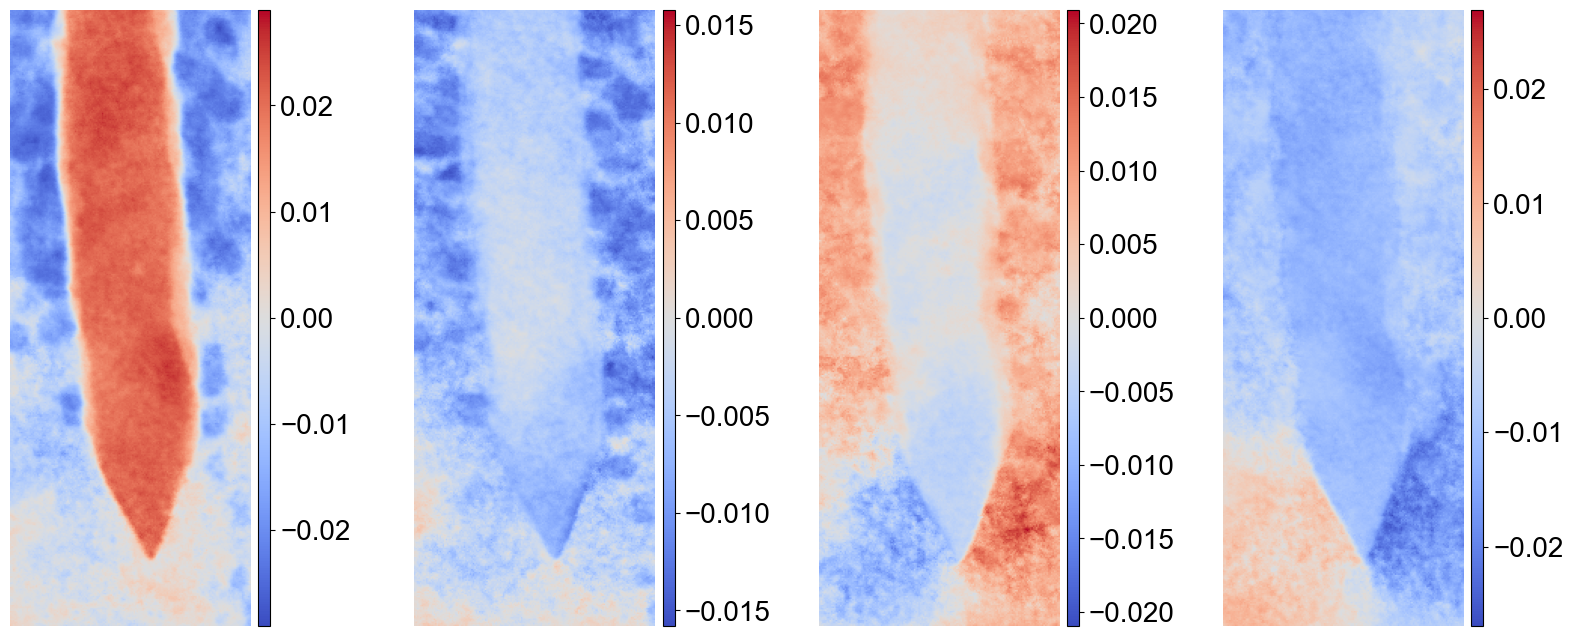

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,8))
im1 = ax1.imshow(eps_xx, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_xx)), vmax = np.max(np.abs(eps_xx)))
ax1.axis('off')
#ax1.set_title('$\epsilon_{xx}$', fontsize = 26)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im1, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)
im2 = ax2.imshow(eps_yy, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_yy)), vmax = np.max(np.abs(eps_yy)))
ax2.axis('off')
#ax2.set_title('$\epsilon_{yy}$', fontsize = 26)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im2, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)
im3 = ax3.imshow(eps_xy, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_xy)), vmax = np.max(np.abs(eps_xy)))
ax3.axis('off')
#ax3.set_title('$\epsilon_{xy}$', fontsize = 26)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im3, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)
im4 = ax4.imshow(eps_yx, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_yx)), vmax = np.max(np.abs(eps_yx)))
ax4.axis('off')
#ax4.set_title('$\epsilon_{yx}$', fontsize = 26)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im4, cax=cax, orientation='vertical').ax.tick_params(labelsize = 20)

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7]) # upper and lower limits, width, and length
# fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 20)
# plt.subplots_adjust(wspace=0)
# plt.show()

plt.show()

(-0.5, 159.5, 409.5, -0.5)

(-0.5, 159.5, 409.5, -0.5)

(-0.5, 159.5, 409.5, -0.5)

(-0.5, 159.5, 409.5, -0.5)

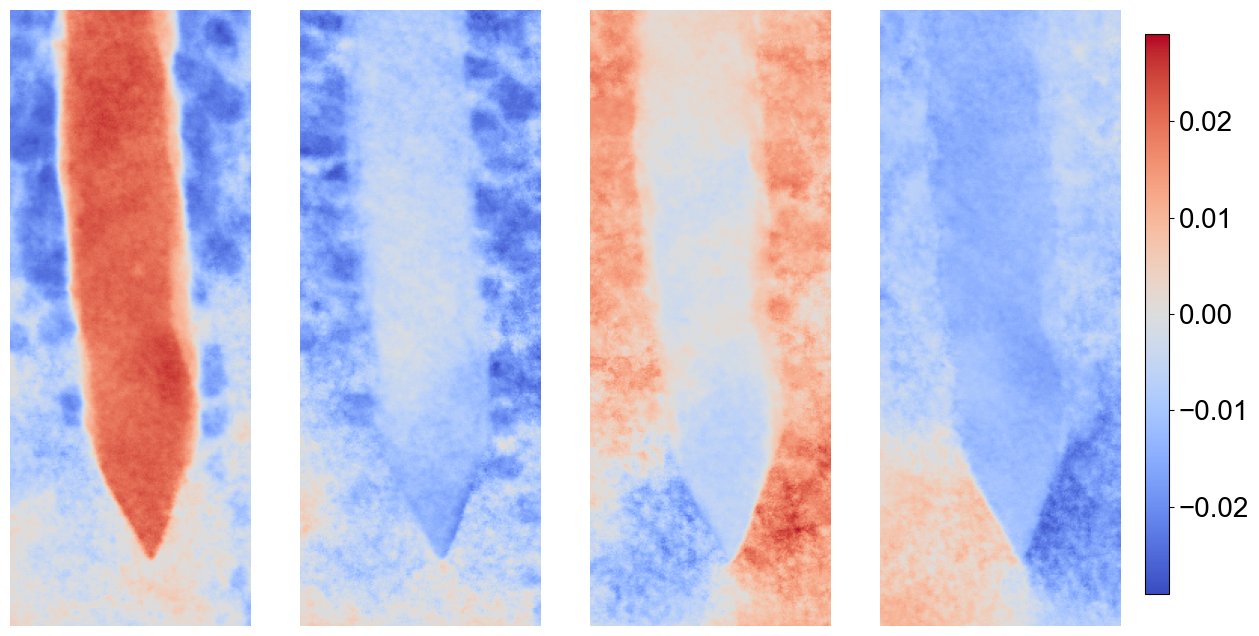

In [61]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (16,8))
im1 = ax1.imshow(eps_xx, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_xx)), vmax = np.max(np.abs(eps_xx)))
ax1.axis('off')
#ax1.set_title('$\epsilon_{xx}$', fontsize = 26)
im2 = ax2.imshow(eps_yy, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_yy)), vmax = np.max(np.abs(eps_yy)))
ax2.axis('off')
#ax2.set_title('$\epsilon_{yy}$', fontsize = 26)

im3 = ax3.imshow(eps_xy, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_xy)), vmax = np.max(np.abs(eps_xy)))
ax3.axis('off')
#ax3.set_title('$\epsilon_{xy}$', fontsize = 26)

im4 = ax4.imshow(eps_yx, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_yx)), vmax = np.max(np.abs(eps_yx)))
ax4.axis('off')
#ax4.set_title('$\epsilon_{yx}$', fontsize = 26)


fig.subplots_adjust(right=.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7]) # upper and lower limits, width, and length
fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 20)
plt.subplots_adjust(wspace=0)
plt.show()

plt.show()